In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import preprocessing
import scipy
import seaborn as sns
from datetime import datetime
from mpl_toolkits.mplot3d import axes3d
import plotly.express as px
import folium


In [2]:
!pip install st_dbscan
from st_dbscan import ST_DBSCAN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 414 kB 5.5 MB/s 
  Created wheel for st-dbscan: filename=st_dbscan-0.2.2-py2.py3-none-any.whl size=6846 sha256=514248e14f454b79b7ac403c95087a9e57e2c188f704fa3b5c7b922890944e0d
  Stored in directory: /root/.cache/pip/wheels/24/91/29/05225600a7692feed03a950616ef6796185cf266de56f521f0
Successfully built st-dbscan


In [ ]:
df = pd.read_csv('eswd_reports_europe_1970_2022.csv',)
df.dropna(axis = 1, how = 'all',inplace = True)
#df.isnull().sum()


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mycol = ['ID','QC_LEVEL','TIME_EVENT','TIME_ACCURACY','LATITUDE','LONGITUDE','PLACE_ACCURACY','COUNTRY','MAX_HAIL_DIAMETER']
df2 = df[mycol]

In [3]:
def date(df2):
    indices = []
    for i in range(len(df2)):
        a = float(df2.iloc[i,2][0:4])
        if a > 2006:
            id = df2.iloc[i,0]
            indices.append(i)
    return indices

In [ ]:
indices = date(df2)
df3 = df2.loc[indices,:] #we get data after 2007

df3.dropna(axis = 0, subset = ['TIME_ACCURACY'],inplace = True)

In [4]:
valide = ['5M','15M','1H','30M','3H','6H','12H'] #we don't want unprecise observations

In [5]:
def precision(df3):
    L = df3['TIME_ACCURACY'].to_numpy()
    n = len(L)
    indices2 = []
    for i in range(n):
        if L[i] in valide:
            indices2.append(i)
    return indices2

In [ ]:
indices2 = precision(df3)

df4 = df3.iloc[indices2,:] # we drop observartions with time acc => 1D

In [6]:
def get_year(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.year
    return dt

In [ ]:
df4['YEAR']=df4.apply(lambda data: get_year(data), axis=1) #we create a YEAR column to help select our training set

<ipython-input-16-68431a6636c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['YEAR']=df4.apply(lambda data: get_year(data), axis=1) #we create a YEAR column to help select our training set


In [ ]:
df4['TIME_EVENT'] = pd.to_datetime(df4['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S') #we put the columns time_event in datetime format

<ipython-input-17-3d4aee671beb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['TIME_EVENT'] = pd.to_datetime(df4['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S') #we put the columns time_event in datetime format


In [ ]:
df4.tail(2)

,ID,QC_LEVEL,TIME_EVENT,TIME_ACCURACY,LATITUDE,LONGITUDE,PLACE_ACCURACY,COUNTRY,MAX_HAIL_DIAMETER,YEAR
43610,37754,QC0+,2007-01-16 02:00:00,1H,43.600,39.730,NaN,RU,2.0,2007
43611,138397,QC0+,2007-01-10 18:05:00,5M,53.367,9.717,NaN,DE,1.5,2007


In [7]:
#we initialize the first observation of our database at t=0 then we calculate time spent since in hours  
def convert_to_hour(df4,j):
    dftemps = df4.copy()
    début = df4.iloc[-1,j]
    for i in range(len(df4)):
        diff = (df4.iloc[i,j] - début).days*24 + (df4.iloc[i,j]-début).seconds/3600
        dftemps.iloc[i,j] = diff
    return dftemps

In [ ]:
df5 = convert_to_hour(df4,2) #we numerize time between observations (1 unit = 1 hour)

In [ ]:
df5

,ID,QC_LEVEL,TIME_EVENT,TIME_ACCURACY,LATITUDE,LONGITUDE,PLACE_ACCURACY,COUNTRY,MAX_HAIL_DIAMETER,YEAR
0,53078,QC1,138376.166667,5M,45.567,5.933,1KM,FR,2.0,2022
1,53079,QC1,138375.783333,5M,45.596,5.875,3KM,FR,2.0,2022
2,3784,QC1,138358.916667,15M,50.967,2.667,3KM,BE,2.5,2022
3,3785,QC1,138358.916667,15M,51.000,2.700,1KM,BE,NaN,2022
4,53038,QC0+,138358.416667,5M,49.583,1.358,1KM,FR,4.5,2022
...,...,...,...,...,...,...,...,...,...,...
43606,140169,QC0+,1171.916667,15M,51.483,7.217,NaN,DE,2.0,2007
43608,140167,QC0+,192.916667,15M,52.150,14.650,NaN,DE,NaN,2007
43609,138396,QC1,191.083333,15M,52.083,10.333,NaN,DE,2.0,2007
43610,37754,QC0+,127.916667,1H,43.600,39.730,NaN,RU,2.0,2007


In [ ]:
data2022 = df5[df5.YEAR == 2022]
dataFR22 = data2022[data2022.COUNTRY == 'FR']

In [ ]:
dataFR22

,ID,QC_LEVEL,TIME_EVENT,TIME_ACCURACY,LATITUDE,LONGITUDE,PLACE_ACCURACY,COUNTRY,MAX_HAIL_DIAMETER,YEAR
0,53078,QC1,138376.166667,5M,45.567,5.933,1KM,FR,2.0,2022
1,53079,QC1,138375.783333,5M,45.596,5.875,3KM,FR,2.0,2022
4,53038,QC0+,138358.416667,5M,49.583,1.358,1KM,FR,4.5,2022
5,53048,QC1,138358.333333,5M,49.533,1.267,1KM,FR,4.0,2022
6,53066,QC1,138358.3,5M,49.521,1.251,1KM,FR,6.0,2022
...,...,...,...,...,...,...,...,...,...,...
7274,50233,QC1,133961.583333,15M,43.279,2.460,1KM,FR,NaN,2022
7275,50205,QC1,133944.416667,5M,44.600,-0.933,5KM,FR,NaN,2022
7308,49896,QC1,133604.2,5M,48.669,5.114,3KM,FR,2.5,2022
7309,49894,QC1,133604.083333,5M,48.636,4.952,3KM,FR,3.5,2022


In [ ]:
data_fin = dataFR22[['TIME_EVENT','LATITUDE','LONGITUDE']] #FR & 2022
dtf_X = data_fin.copy() #base to train model

In [ ]:
model = ST_DBSCAN(eps1=0.4, eps2=4,
                         min_samples=2)
model.fit(dtf_X)

In [ ]:
classi = model.labels

In [ ]:
dtf_X_results = dtf_X.copy()
dtf_X_results['CLASSI'] = classi

In [ ]:
np.unique(classi) #number of clusters we find with model -1 (trash cluster)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159])

In [ ]:
def cluster(data,classi):
    orages = []
    n = len(data)
    p = len(np.unique(classi))
    for j in range(p):
        L = []
        for i in range(n):
            if classi[i] == np.unique(classi)[j]:
                L.append(i)
        orages.append(L)
    return orages

In [ ]:
orages = cluster(dtf_X,classi)

In [8]:
# à tester pour voir si amélioration de cluster
def cluster2(data,classi):
    orages = []
    n = len(data)
    p = len(np.unique(classi))
    for j in range(p):
        L = np.where(classi == j-1)[0]
        orages.append(L)
    return orages

In [ ]:
orages_test = cluster2(dtf_X,classi)

In [ ]:
#we check cluster = cluster2
if len(orages_test) == len(orages):
  L = []
  for i in range(len(orages_test)):
    L.append(sum(orages_test[i] == orages[i]))
print(sum(L) == len(dtf_X))

NameError: ignored

In [ ]:
#we only use cluster2 which is faster than cluster

In [ ]:
orages_fin = cluster2(dtf_X,classi)

In [ ]:
#mean number of observations per cluster
c=0
for i in range(1,len(orages_fin)):
    c+= len(orages_fin[i])
print(c/(len(orages_fin)-1))


15.941176470588236


In [ ]:
#distribution of the number of observations per cluster
l=[]
for i in range(1,len(orages_fin)):
    l.append(len(orages_fin[i]))

# l = np.unique(classi, return_counts = True)[1]

In [ ]:
l = np.unique(classi, return_counts = True)[1]

In [ ]:
np.mean(l[1:])

15.941176470588236

In [ ]:
l.tolist().index(np.max(l))

43

In [ ]:
np.max(l),orages_fin[l.tolist().index(np.max(l))]

(244, array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
        430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
        456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
        469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
        482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
        495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
        508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
        521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
        534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
        547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
        560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
        573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585,
        586, 587, 588, 589, 590, 591, 592, 593

In [ ]:
oragesmax = dtf_X_results[dtf_X_results.CLASSI == l.tolist().index(np.max(l))-1]

In [ ]:
oragesmax

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
3206,135508.166667,47.471,7.308,42
3207,135508.083333,47.533,7.183,42
3208,135508.05,47.549,7.157,42
3209,135508.05,47.502,7.166,42
3210,135508.0,47.564,7.151,42
...,...,...,...,...
3445,135504.7,48.186,6.791,42
3446,135504.7,48.217,6.800,42
3447,135504.466667,47.756,6.131,42
3448,135504.066667,47.885,6.273,42


In [ ]:
oragesmax.describe() #in order to analyze the orage

,LATITUDE,LONGITUDE,CLASSI
count,244.000000,244.000000,244.0
mean,47.942176,6.961381,42.0
std,0.515053,0.546645,0.0
min,47.000000,5.457000,42.0
25%,47.531250,6.667750,42.0
50%,47.893000,7.003500,42.0
75%,48.450250,7.412000,42.0
max,48.801000,7.905000,42.0


In [ ]:
diff_lat = oragesmax.describe().iloc[-1,0] - oragesmax.describe().iloc[3,0]
diff_long = oragesmax.describe().iloc[-1,1] - oragesmax.describe().iloc[3,1]
diff_lat, diff_long

(1.801000000000002, 2.4480000000000004)

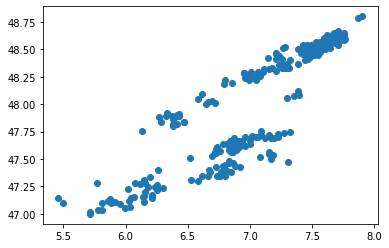

In [ ]:
longitude = [oragesmax.iloc[i,2] for i in range(len(oragesmax))]
latitude = [oragesmax.iloc[i,1] for i in range(len(oragesmax))]
plt.scatter(longitude,latitude)
plt.show()

In [ ]:
#sûrement 2 orages ???

In [ ]:
#we plot the distribution of the clustering (number of observations per storm)

In [ ]:
np.unique(classi, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159]),
 array([137,   2,   7,   7,   8,  17,   6,   2,   5,   3,   3,   2,   4,
          2,  19

In [ ]:
len(l)

161

In [ ]:
l

array([ 83,   2,  26,  15,   6,   2,   5,   3,   3,   2,   4,   2,  23,
        19,   3,   6,   2,   3,   2,   2,   5,   5,  11,  21,  17,   4,
         2,   4,   2,   2,   2,   2,   2,   3,   2,  15,  67,   8,   7,
         2,  26,  33,   7, 244,   2,  16,  15,  14,   2,  11,   3,   8,
         6,   6,  15,   7,   6,   2,   2,   3,   4,   2,   2,   4,  63,
       114,  76, 125,  17,   6,   4,   2,   5,   3,   2,  21,   2,   2,
       190,   3,   4,  11,   2,   3,   4,  10,  12,  38,   4,  23,  10,
         6,  33,   2,   2,   9,   3, 120,  10,   2,  73,  19,   9,   9,
         5,   3,  29,   4,  10,   2,   2,   5,   9,   2,   2,   4,   4,
         2,   6,   2])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'distribution du nombre de rapports par cluster')

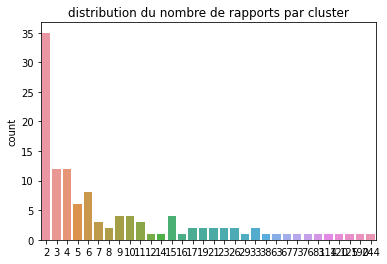

In [ ]:
sns.countplot(l).set_title("distribution du nombre de rapports par cluster")

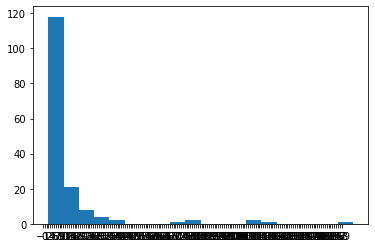

In [ ]:
labels, count = np.unique(classi, return_counts=True)
plt.hist(count[1:], bins = 20)
plt.gca().set_xticks(labels)
plt.show()

In [ ]:
#plot 1 track 
orages1 = orages_fin[1]
longitude = [dtf_X.iloc[i,2] for i in orages1]
latitude = [dtf_X.iloc[i,1] for i in orages1]
plt.scatter(longitude,latitude)
plt.show()

In [9]:
#to plot j tracks excluding the first one (too many erratic observations)
def constru(X,orages,j,l):
    m = len(orages)
    figure = plt.figure(figsize = (20, 10))
    if j == -1:
        j = m
    for o in range(1,j):
        longitude = [X.iloc[i,2] for i in orages[o]]
        latitude = [X.iloc[i,1] for i in orages[o]]
        plt.scatter(longitude,latitude)
    if j<len(l)-2 :
      plt.title('tracé des n='+str(j-1)+' premiers orages sans le cluster -1')
    else:
      plt.title('tracé de tous les orages sans le cluster -1')
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')
    plt.legend()
    plt.show()

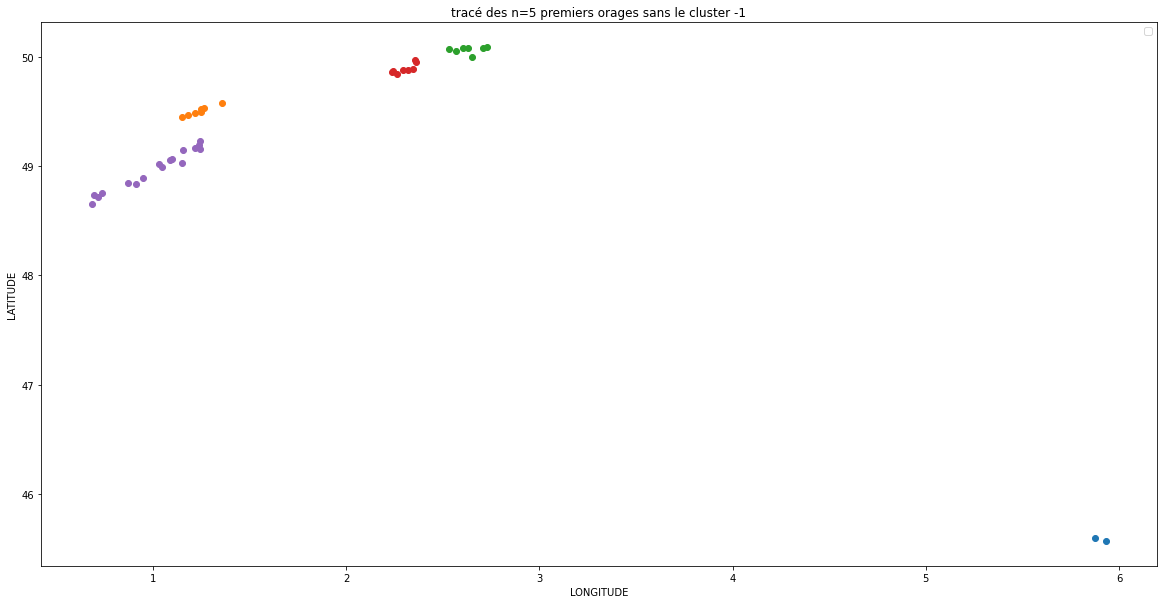

In [ ]:
constru(dtf_X,orages_fin,6)

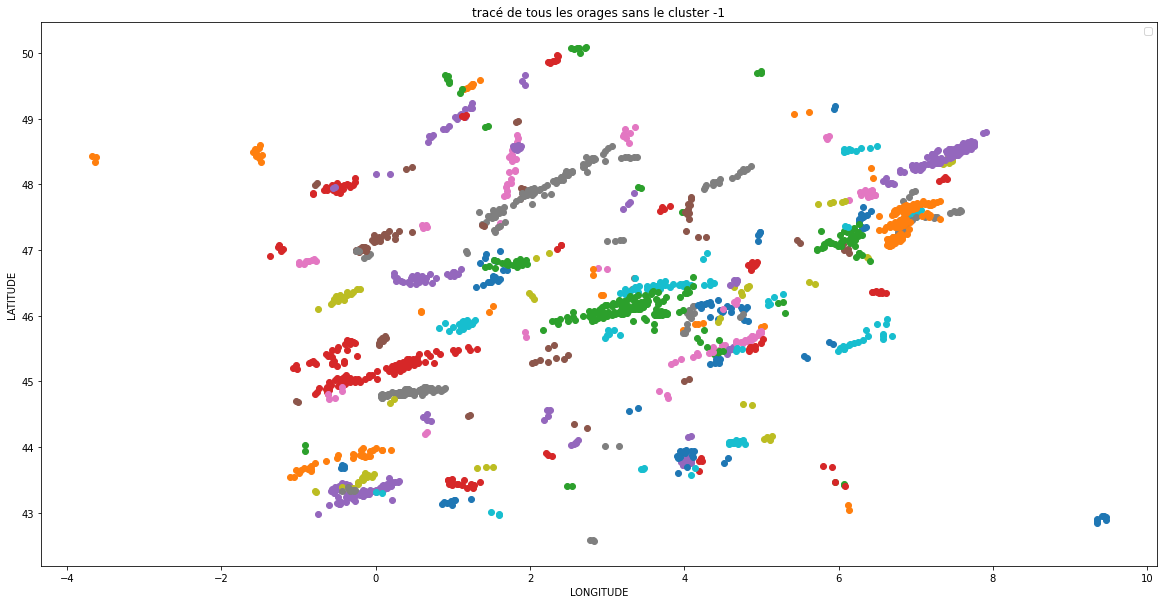

In [ ]:
constru(dtf_X,orages_fin,159)

In [ ]:
orages_test = dtf_X_results[dtf_X_results.CLASSI == 42]

In [ ]:
dtf_X_results.describe().iloc[-1,-1]

159.0

In [ ]:
orages_test

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
3206,135508.166667,47.471,7.308,42
3207,135508.083333,47.533,7.183,42
3208,135508.05,47.549,7.157,42
3209,135508.05,47.502,7.166,42
3210,135508.0,47.564,7.151,42
...,...,...,...,...
3445,135504.7,48.186,6.791,42
3446,135504.7,48.217,6.800,42
3447,135504.466667,47.756,6.131,42
3448,135504.066667,47.885,6.273,42


In [ ]:
m = folium.Map(
            location=[46.8534, 2.3488],
            zoom_start=6
	    )


In [ ]:
points = []
for i in range(len(orages_test)):
  longi = orages_test.iloc[i,2]
  lati = orages_test.iloc[i,1]
  points.append((lati,longi))
  #ajouter cette liste de points à la carte
folium.PolyLine(points, color="red", weight=5, opacity=0.8).add_to(m)

In [ ]:
m

In [ ]:
map = folium.Map(location=[46.8534, 2.3488],zoom_start=6)

In [ ]:
def mapping_FR(dtf_X_results):
  map = folium.Map(location=[46.8534, 2.3488],zoom_start=6)
  n = int(dtf_X_results.describe().iloc[-1,-1])
  colors = ["red",'blue',"green","yellow",'orange','brown','black','purple']
  for i in range(n):
    orages_boucle = dtf_X_results[dtf_X_results.CLASSI == i]
    points = []
    for j in range(len(orages_boucle)):
      longi = orages_boucle.iloc[j,2]
      lati = orages_boucle.iloc[j,1]
      points.append((lati,longi))
    folium.PolyLine(points, color=colors[i%8], weight=5, opacity=0.8).add_to(map)
  map

In [ ]:
mapping_FR(dtf_X_results)

# data must have been imported in the column on the left of the notebook
# functions that must have been defined : date, precision, get_year, convert_to_hour, cluster2, constru

In [10]:
def prep_data():
  df = pd.read_csv('eswd_reports_europe_1970_2022.csv',)
  df.dropna(axis = 1, how = 'all',inplace = True)
  mycol = ['ID','QC_LEVEL','TIME_EVENT','TIME_ACCURACY','LATITUDE','LONGITUDE','PLACE_ACCURACY','COUNTRY','MAX_HAIL_DIAMETER']
  df2 = df[mycol]
  indices = date(df2)
  df3 = df2.loc[indices,:]
  df3.dropna(axis = 0, subset = ['TIME_ACCURACY'],inplace = True)
  valide = ['5M','15M','1H','30M','3H','1M','6H','12H']
  indices2 = precision(df3)
  df4 = df3.iloc[indices2,:]
  df4['YEAR']=df4.apply(lambda data: get_year(data), axis=1)
  df4['TIME_EVENT'] = pd.to_datetime(df4['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
  df5 = convert_to_hour(df4,2) #take 1 minute to proceed
  return df5

In [11]:
df5 = prep_data()

<ipython-input-11-523a79b3e054>:1: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types.Specify dtype option on import or set low_memory=False.
  df5 = prep_data()
<ipython-input-10-65284f6d682c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['YEAR']=df4.apply(lambda data: get_year(data), axis=1)
<ipython-input-10-65284f6d682c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['TIME_EVENT'] = pd.to_datetime(df4['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')


In [12]:
def visu(df5,country,year,var_eps1,var_eps2,var_min_samples):
  print('model = spatial: ',var_eps1,', time :',var_eps2,', min_samples :',var_min_samples )
  data = df5[df5.YEAR == year]
  data = data[data.COUNTRY == country]
  data_visu = data[['TIME_EVENT','LATITUDE','LONGITUDE']]
  model_visu = ST_DBSCAN(eps1=var_eps1, eps2=var_eps2,
                         min_samples=var_min_samples)
  model_visu.fit(data_visu)
  classi_visu = model_visu.labels
  visu_results = data_visu.copy()
  visu_results['CLASSI'] = classi_visu
  orages_visu = cluster2(data_visu,classi_visu)
  #stats about clustering distribution 
  # l_visu : list with number of observations per orage without the -1
  l_visu = np.unique(classi_visu, return_counts = True)[1]
  #number of clusters
  print('we cluster',len(l_visu)-1,'orages in',country,'during the year',year)
  percentage = round((l_visu[0]/len(data_visu))*100,1)
  print("we can't cluster", l_visu[0],'obsverations over',len(data_visu),'(',percentage,'%)')
  #mean observations per orage
  print('In',country,'during the year',year,'the mean number of observations per orage is', round(np.mean(l_visu[1:]),3))
  print('In',country,'during the year',year,'the median number of observations per orage is', np.median(l_visu[1:]))
  # max obsverations for an orage
  orage_max = l_visu.tolist().index(np.max(l_visu[1:]))
  print('the biggest orage has been reported',np.max(l_visu[1:]),'times')
  data_max = visu_results[visu_results.CLASSI == (orage_max -1)]
  #we check the size of this orage
  large = round(data_max.describe().iloc[-1,1] - data_max.describe().iloc[3,1],3)
  high = round(data_max.describe().iloc[-1,0] - data_max.describe().iloc[3,0],3)
  timezer = round(data_max.iloc[0,0] - data_max.iloc[-1,0],1)
  hours = int(timezer)
  minutes = round((timezer - hours)*60)
  print('the biggest orage has moved :',large,'longitude degrees and',high,'latitude degrees')
  print('the biggest orage has last :',hours,'h',minutes,'min')
  #we plot this orage_max
  plt.figure(1)
  longitude = [data_max.iloc[i,2] for i in range(len(data_max))]
  latitude = [data_max.iloc[i,1] for i in range(len(data_max))]
  temps = [data_max.iloc[i,0] - data_max.iloc[-1,0] for i in range(len(data_max))]
  plt.scatter(longitude,latitude, c = temps)
  cbar = plt.colorbar()
  cbar.set_label('Time Evolution')
  plt.title('track of the biggest orage')
  plt.show()
  #plot the distribution of the number of obsverations per cluster
  sns.displot(x = l_visu)#.set_title("distribution of the number of observations per cluster")
  #we plot all of the orages
  constru(data_visu,orages_visu,len(l_visu)-2,l_visu)
  return visu_results


model = spatial:  0.1 , time : 2 , min_samples : 2
we cluster 202 orages in FR during the year 2022
we can't cluster 248 obsverations over 1980 ( 12.5 %)
In FR during the year 2022 the mean number of observations per orage is 8.574
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 118 times
the biggest orage has moved : 0.833 longitude degrees and 0.169 latitude degrees
the biggest orage has last : 2 h 42 min


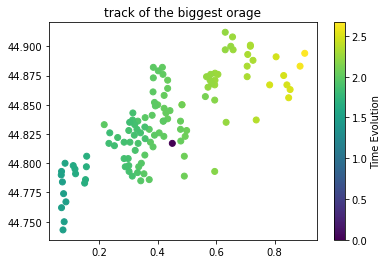

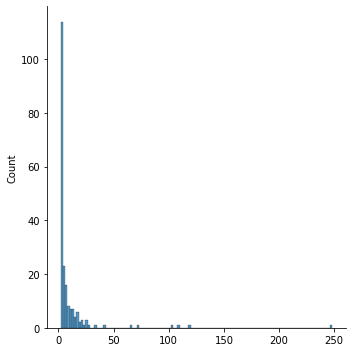

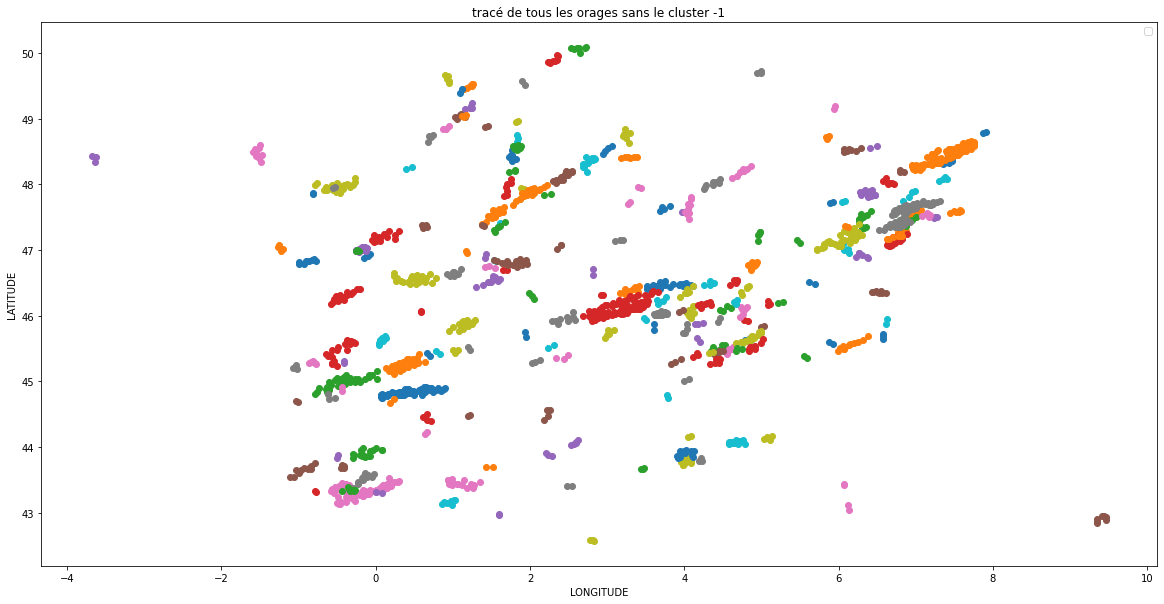

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,0
1,138375.783333,45.596,5.875,0
4,138358.416667,49.583,1.358,-1
5,138358.333333,49.533,1.267,1
6,138358.3,49.521,1.251,1
...,...,...,...,...
7274,133961.583333,43.279,2.460,201
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,-1
7309,133604.083333,48.636,4.952,-1


In [13]:
visu(df5,'FR',2022,0.1,2,2)

model = spatial:  0.2 , time : 3 , min_samples : 2
we cluster 160 orages in FR during the year 2022
we can't cluster 137 obsverations over 1980 ( 6.9 %)
In FR during the year 2022 the mean number of observations per orage is 11.519
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 165 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 6 h 30 min


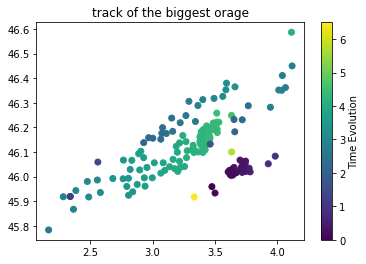

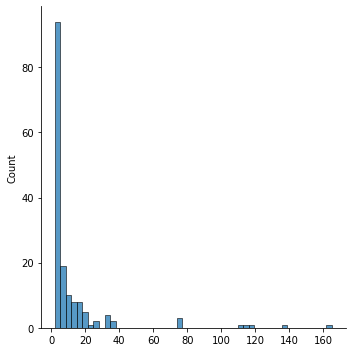

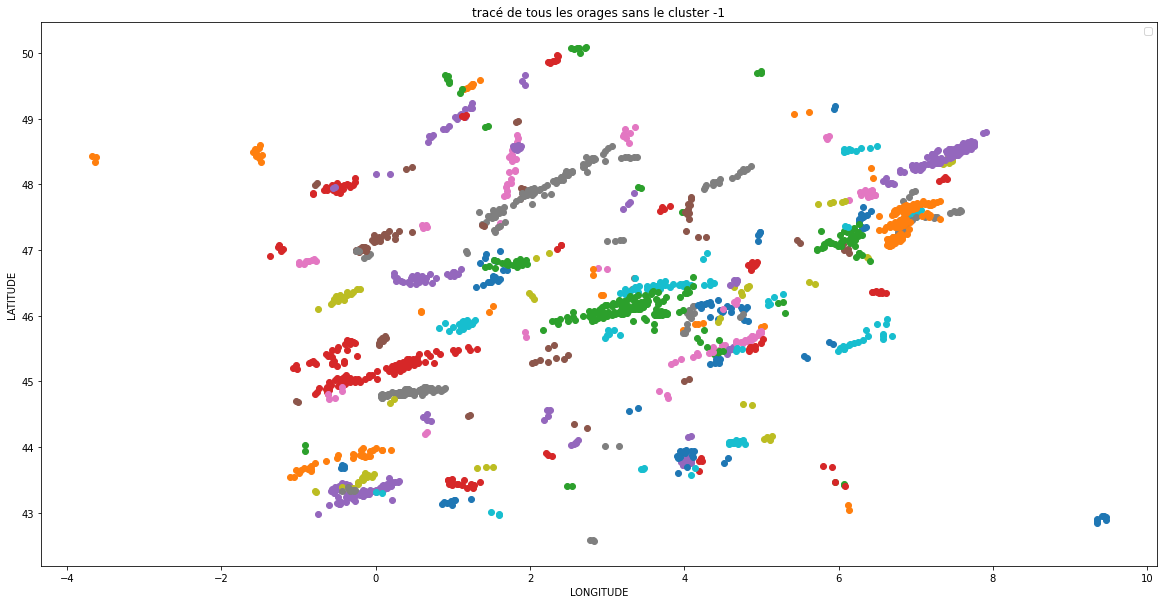

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,0
1,138375.783333,45.596,5.875,0
4,138358.416667,49.583,1.358,1
5,138358.333333,49.533,1.267,1
6,138358.3,49.521,1.251,1
...,...,...,...,...
7274,133961.583333,43.279,2.460,158
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,159
7309,133604.083333,48.636,4.952,159


In [14]:
visu(df5,'FR',2022,0.2,3,2)

model = spatial:  0.2 , time : 2 , min_samples : 3
we cluster 104 orages in FR during the year 2022
we can't cluster 251 obsverations over 1980 ( 12.7 %)
In FR during the year 2022 the mean number of observations per orage is 16.625
In FR during the year 2022 the median number of observations per orage is 7.5
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


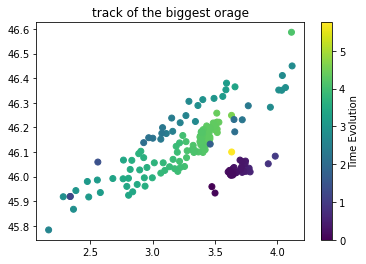

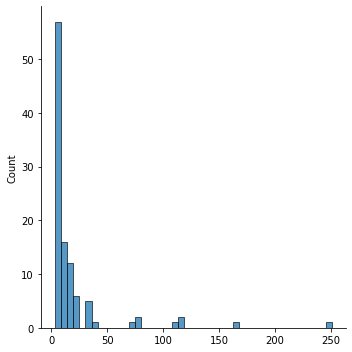

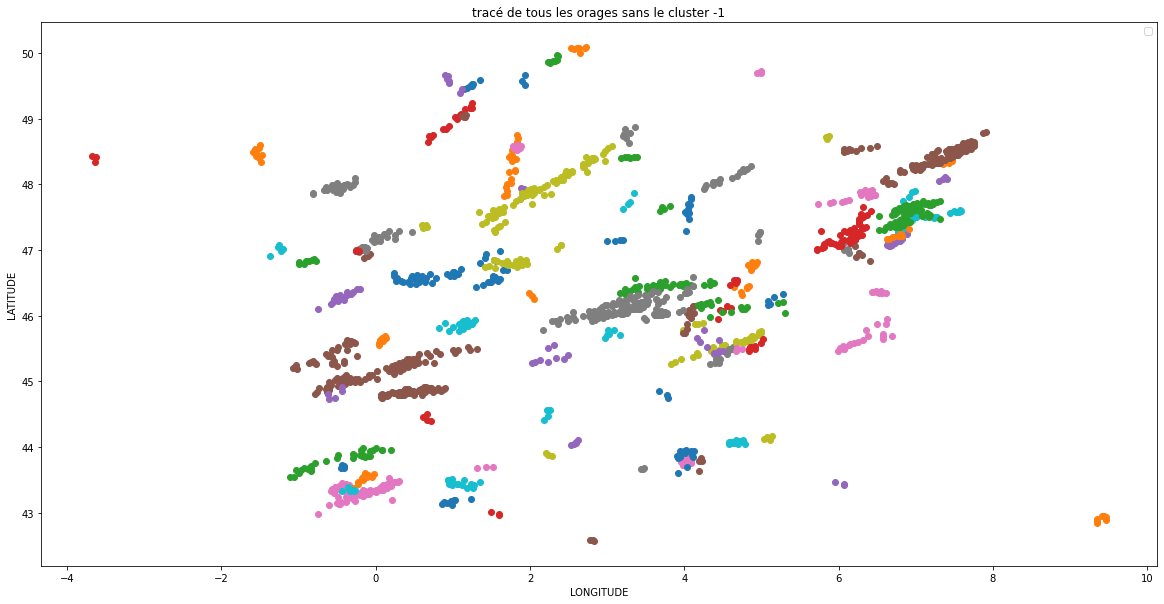

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,-1
1,138375.783333,45.596,5.875,-1
4,138358.416667,49.583,1.358,0
5,138358.333333,49.533,1.267,0
6,138358.3,49.521,1.251,0
...,...,...,...,...
7274,133961.583333,43.279,2.460,103
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,-1
7309,133604.083333,48.636,4.952,-1


In [15]:
visu(df5,'FR',2022,0.2,2,3)

model = spatial:  0.2 , time : 3 , min_samples : 2
we cluster 81 orages in DE during the year 2022
we can't cluster 79 obsverations over 577 ( 13.7 %)
In DE during the year 2022 the mean number of observations per orage is 6.148
In DE during the year 2022 the median number of observations per orage is 3.0
the biggest orage has been reported 58 times
the biggest orage has moved : 1.806 longitude degrees and 0.288 latitude degrees
the biggest orage has last : 5 h 18 min


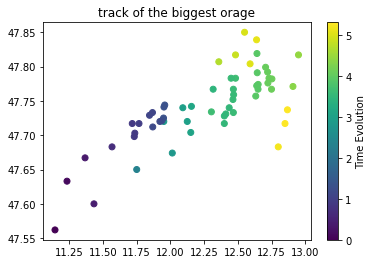

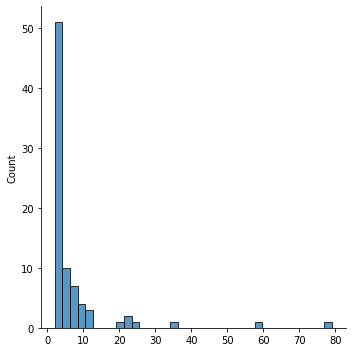

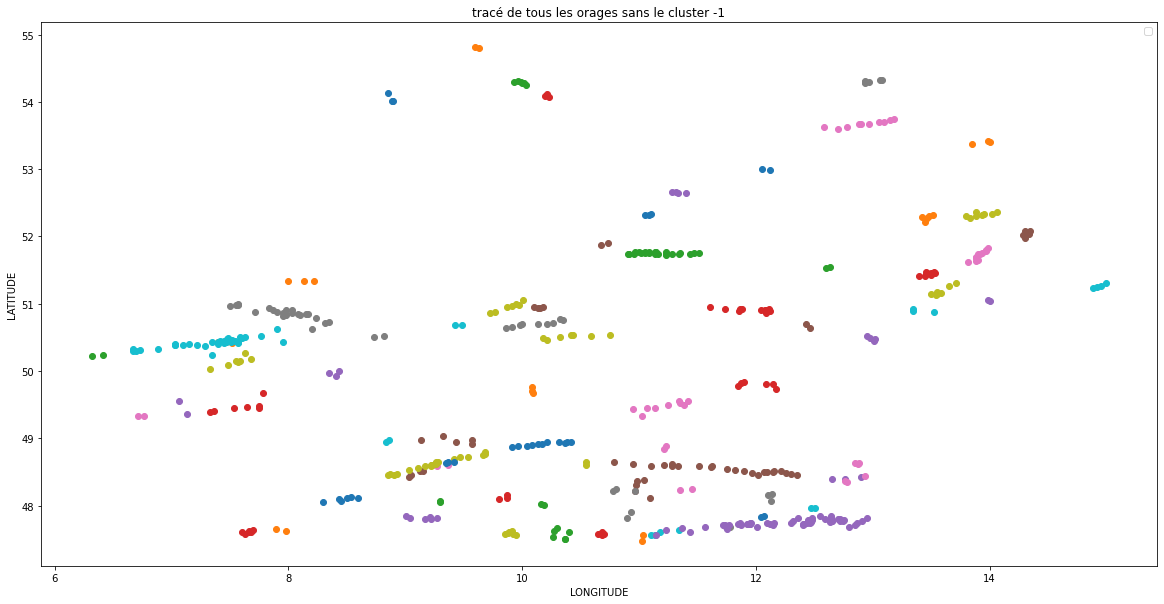

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
183,137544.083333,53.783,11.517,-1
184,137541.583333,53.550,12.983,-1
186,137539.75,52.983,12.117,0
187,137539.75,54.800,9.633,1
188,137539.666667,54.817,9.600,1
...,...,...,...,...
7117,134229.333333,50.667,10.483,-1
7166,134201.35,48.043,8.305,-1
7228,134032.416667,47.900,7.667,-1
7235,134012.583333,50.267,8.450,80


In [17]:
visu(df5,'DE',2022,0.2,3,2)

model = spatial:  0.2 , time : 3 , min_samples : 2
we cluster 64 orages in PL during the year 2021
we can't cluster 89 obsverations over 1067 ( 8.3 %)
In PL during the year 2021 the mean number of observations per orage is 15.281
In PL during the year 2021 the median number of observations per orage is 3.0
the biggest orage has been reported 349 times
the biggest orage has moved : 2.274 longitude degrees and 1.145 latitude degrees
the biggest orage has last : 8 h 42 min


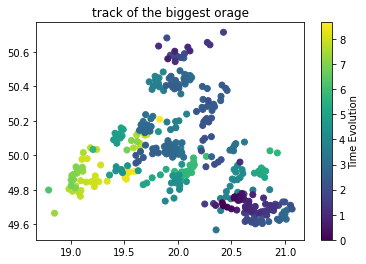

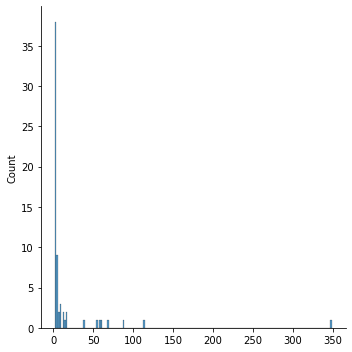

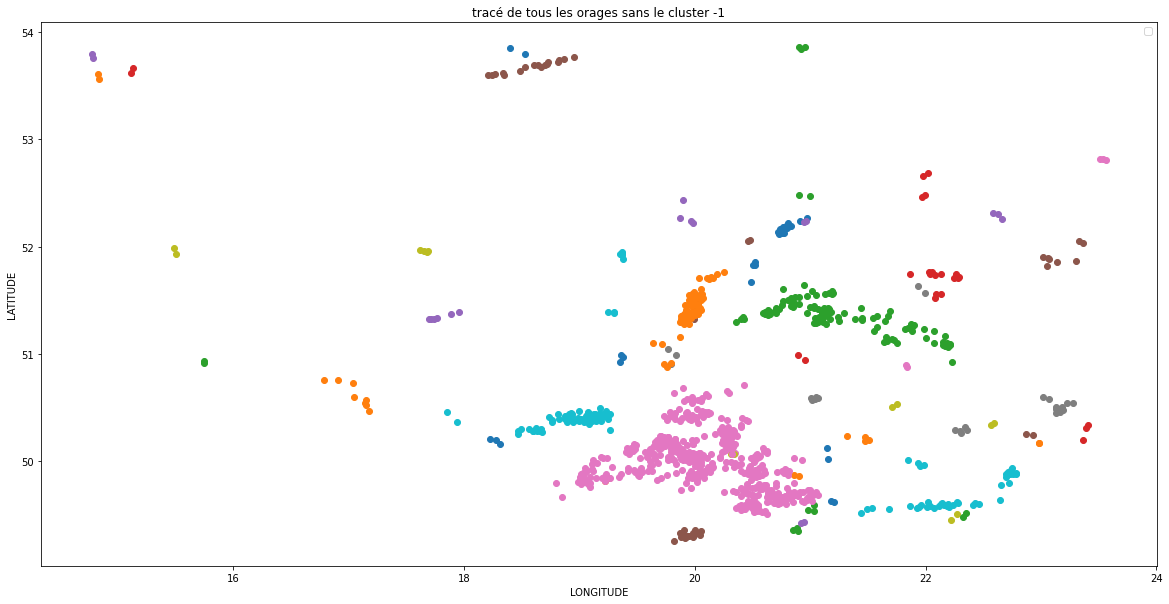

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
7525,128588.083333,52.904,16.732,-1
7526,128586.083333,54.436,17.888,-1
7527,128585.583333,54.256,18.111,-1
7790,127966.133333,52.271,20.975,0
7792,127965.916667,52.237,20.913,0
...,...,...,...,...
12478,125659.916667,50.465,17.175,61
12479,125659.75,50.417,16.442,63
12480,125659.5,50.405,16.289,63
12481,125659.25,50.387,16.361,63


In [18]:
visu(df5,'PL',2021,0.2,3,2)

In [21]:
spatial_params = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
time_params = [1,2,3,4,5,6,7]
sample_params = [1,2,3,4,5,6,7]

In [19]:
def grid(df5,country,year,sp_params,t_params,sa_params):
  for eps1 in sp_params:
    for eps2 in t_params:
      for eps3 in sa_params:
        visu(df5,country,year,eps1,eps2,eps3)

#Influence of spatial threshold in st_dbscan

we fix the time threshold and min_samples parameters and we change spatial threshold

In [20]:
time_fix = [3]
sample_fix = [3]

model = spatial:  0.1 , time : 3 , min_samples : 3
we cluster 136 orages in FR during the year 2022
we can't cluster 376 obsverations over 1980 ( 19.0 %)
In FR during the year 2022 the mean number of observations per orage is 11.794
In FR during the year 2022 the median number of observations per orage is 6.0
the biggest orage has been reported 118 times
the biggest orage has moved : 0.833 longitude degrees and 0.169 latitude degrees
the biggest orage has last : 2 h 42 min


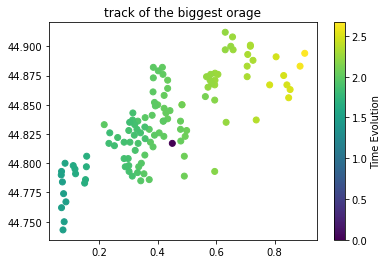

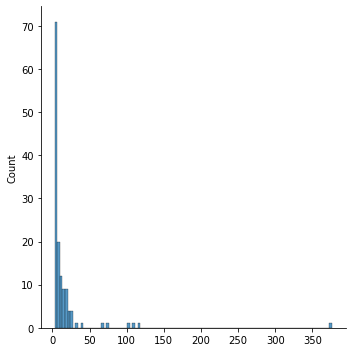

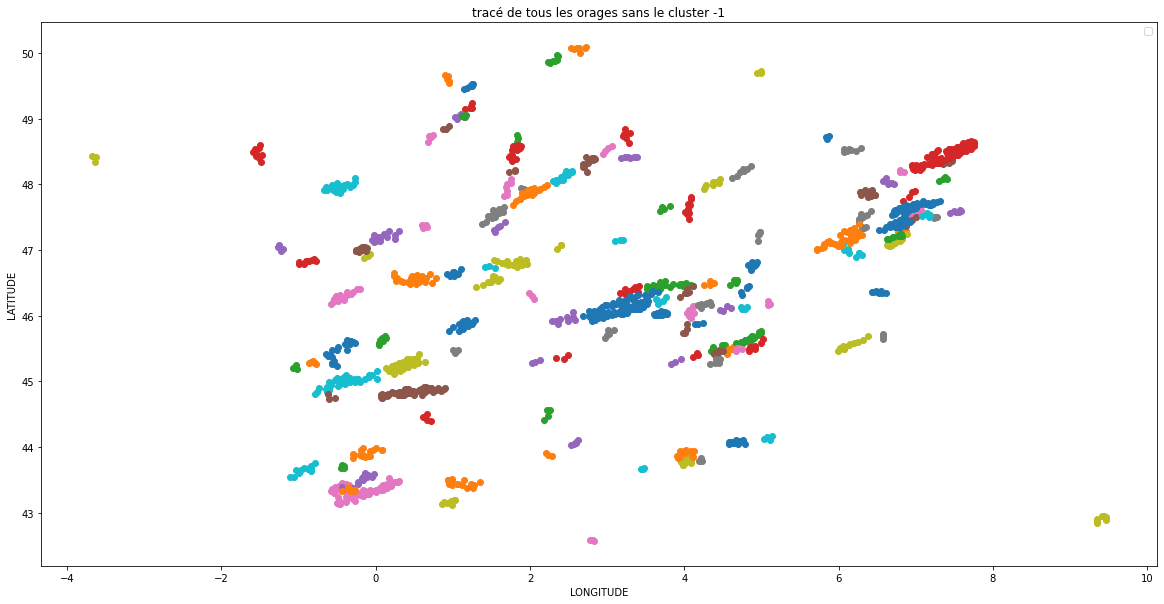

model = spatial:  0.2 , time : 3 , min_samples : 3
we cluster 104 orages in FR during the year 2022
we can't cluster 249 obsverations over 1980 ( 12.6 %)
In FR during the year 2022 the mean number of observations per orage is 16.644
In FR during the year 2022 the median number of observations per orage is 7.5
the biggest orage has been reported 165 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 6 h 30 min


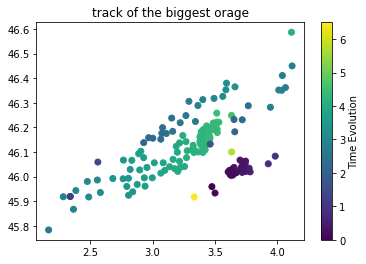

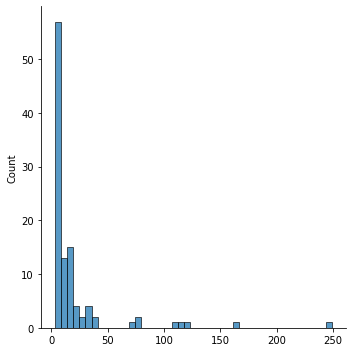

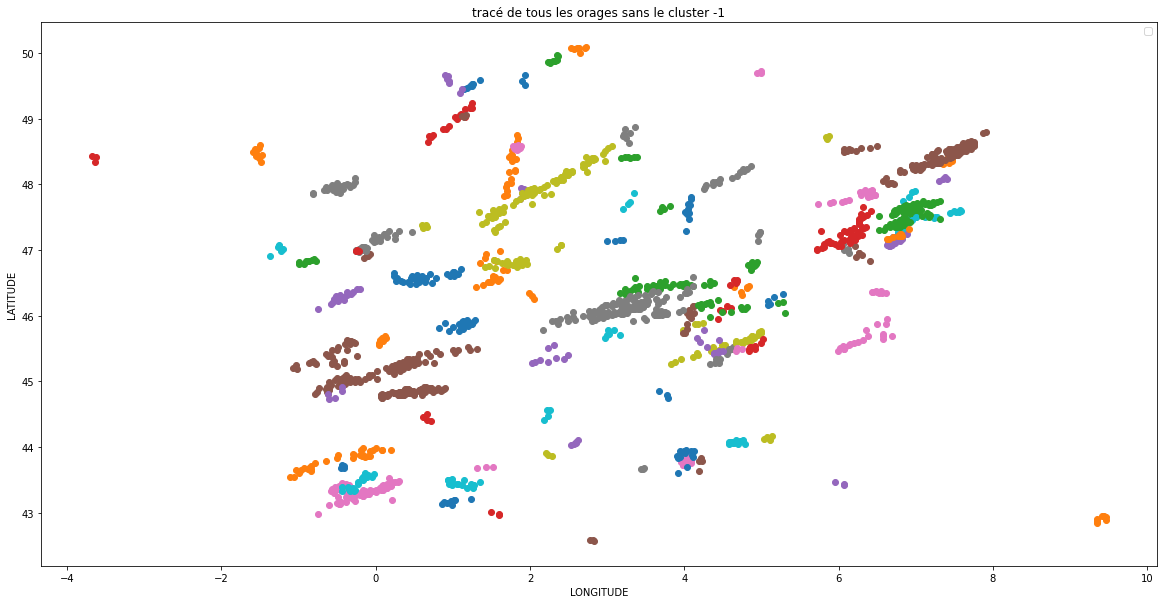

model = spatial:  0.3 , time : 3 , min_samples : 3
we cluster 88 orages in FR during the year 2022
we can't cluster 189 obsverations over 1980 ( 9.5 %)
In FR during the year 2022 the mean number of observations per orage is 20.352
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 186 times
the biggest orage has moved : 2.878 longitude degrees and 1.152 latitude degrees
the biggest orage has last : 7 h 30 min


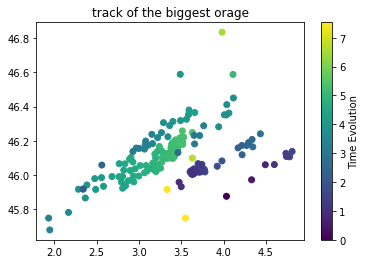

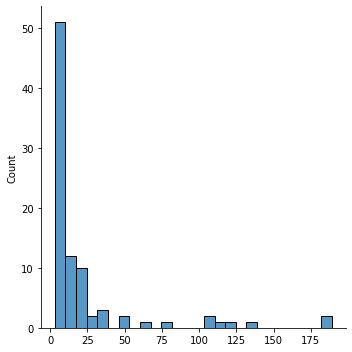

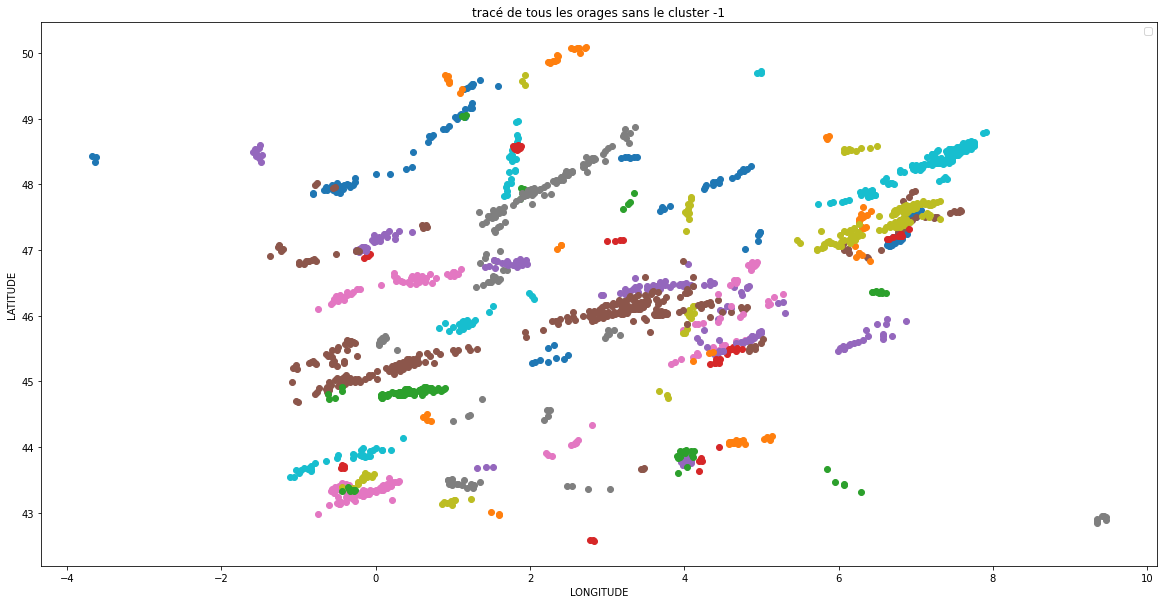

model = spatial:  0.4 , time : 3 , min_samples : 3
we cluster 84 orages in FR during the year 2022
we can't cluster 156 obsverations over 1980 ( 7.9 %)
In FR during the year 2022 the mean number of observations per orage is 21.714
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


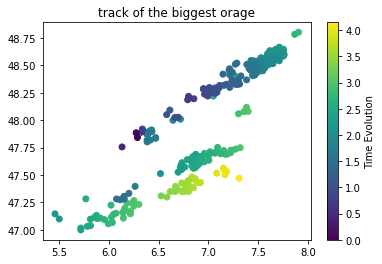

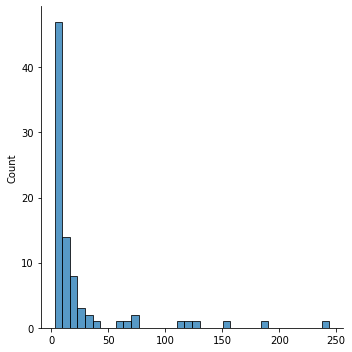

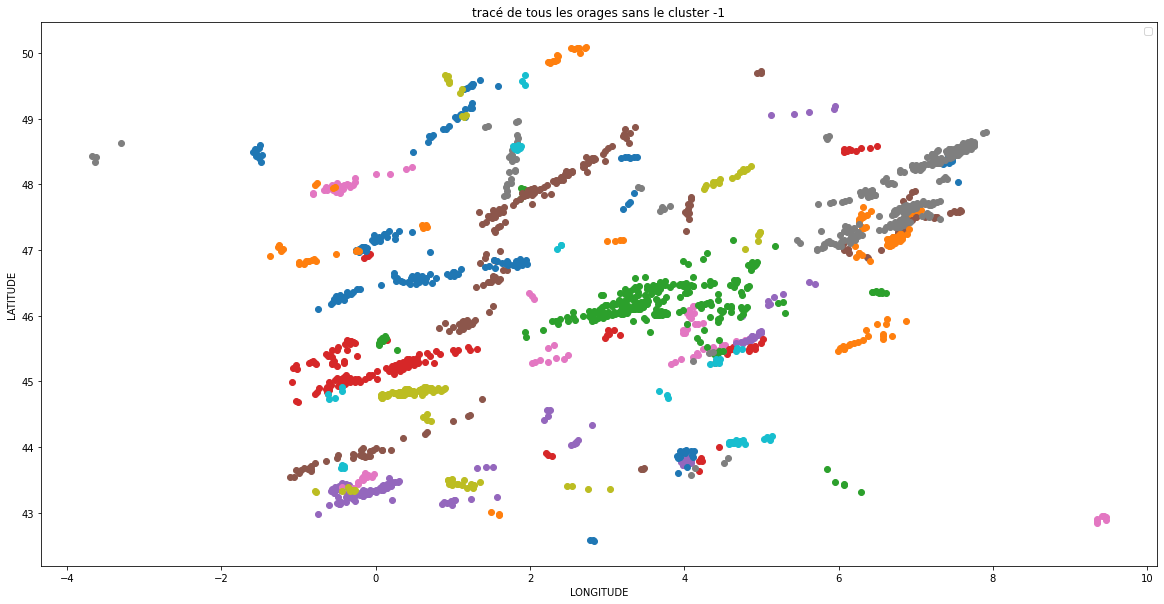

model = spatial:  0.5 , time : 3 , min_samples : 3
we cluster 83 orages in FR during the year 2022
we can't cluster 124 obsverations over 1980 ( 6.3 %)
In FR during the year 2022 the mean number of observations per orage is 22.361
In FR during the year 2022 the median number of observations per orage is 9.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


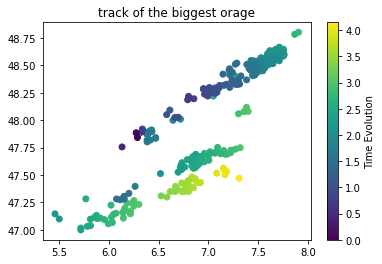

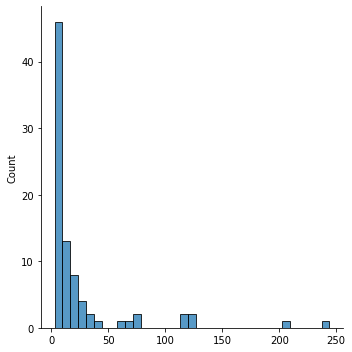

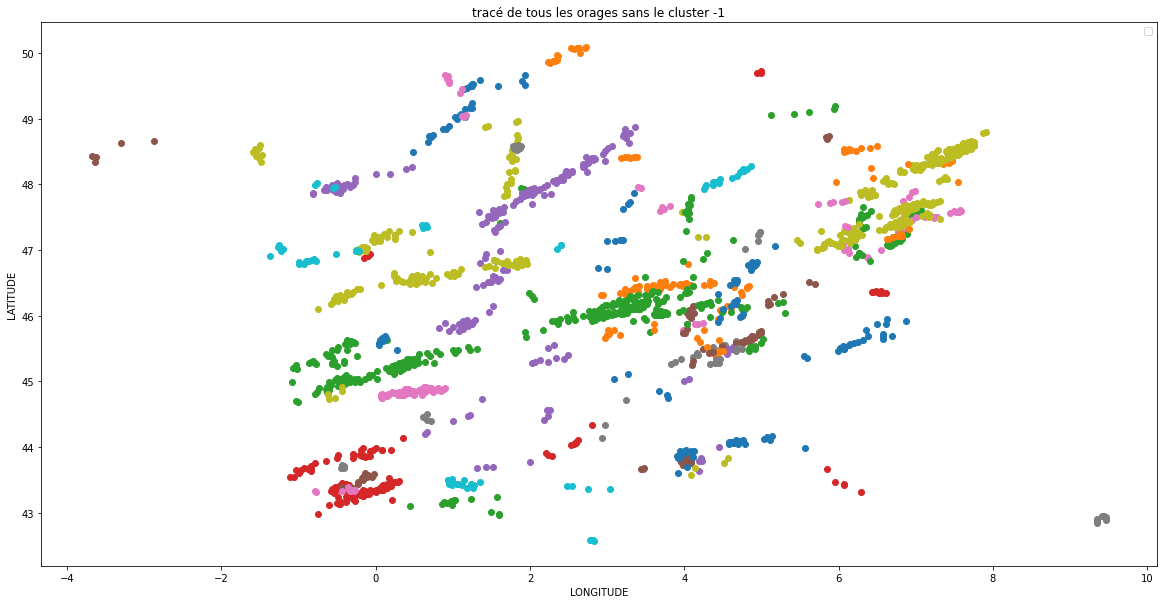

model = spatial:  0.6 , time : 3 , min_samples : 3
we cluster 78 orages in FR during the year 2022
we can't cluster 112 obsverations over 1980 ( 5.7 %)
In FR during the year 2022 the mean number of observations per orage is 23.949
In FR during the year 2022 the median number of observations per orage is 9.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


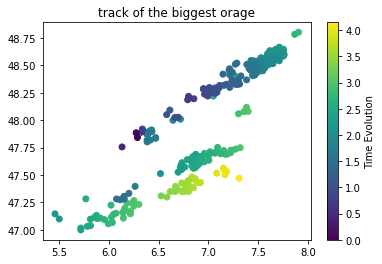

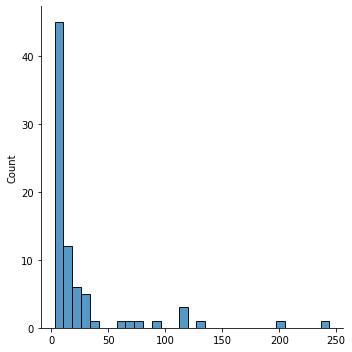

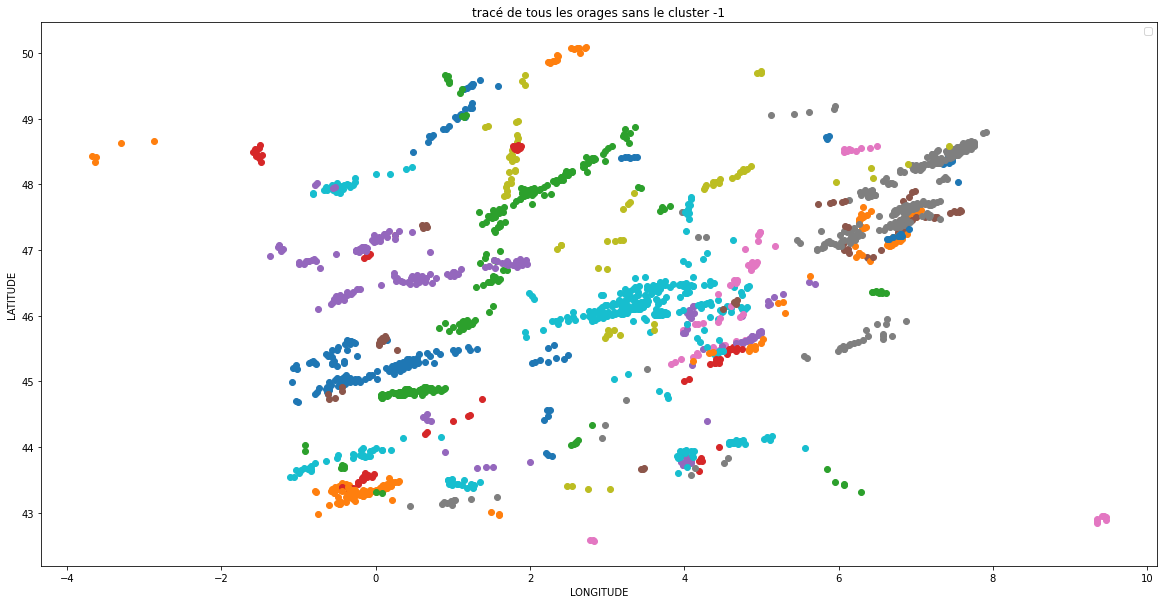

model = spatial:  0.7 , time : 3 , min_samples : 3
we cluster 73 orages in FR during the year 2022
we can't cluster 104 obsverations over 1980 ( 5.3 %)
In FR during the year 2022 the mean number of observations per orage is 25.699
In FR during the year 2022 the median number of observations per orage is 9.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


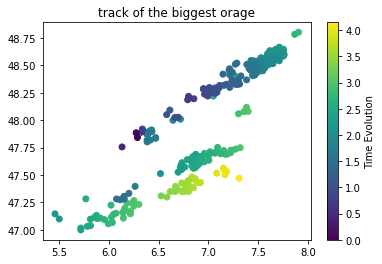

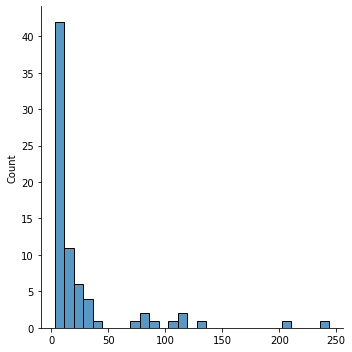

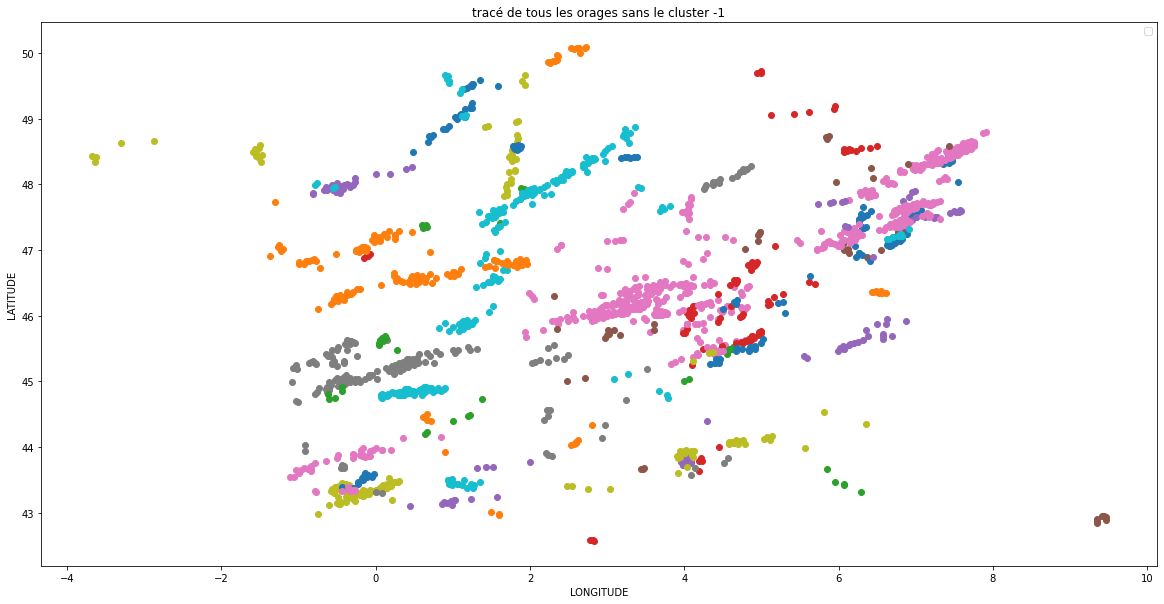

model = spatial:  0.8 , time : 3 , min_samples : 3
we cluster 72 orages in FR during the year 2022
we can't cluster 93 obsverations over 1980 ( 4.7 %)
In FR during the year 2022 the mean number of observations per orage is 26.208
In FR during the year 2022 the median number of observations per orage is 9.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


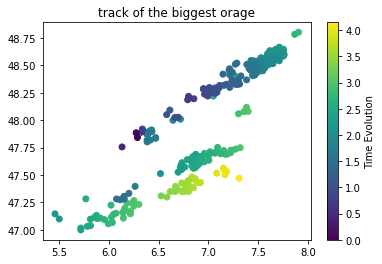

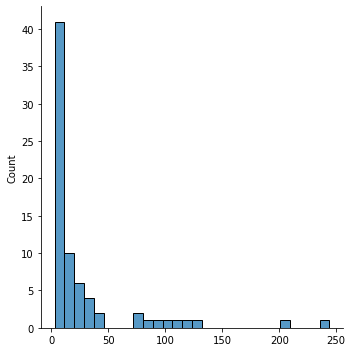

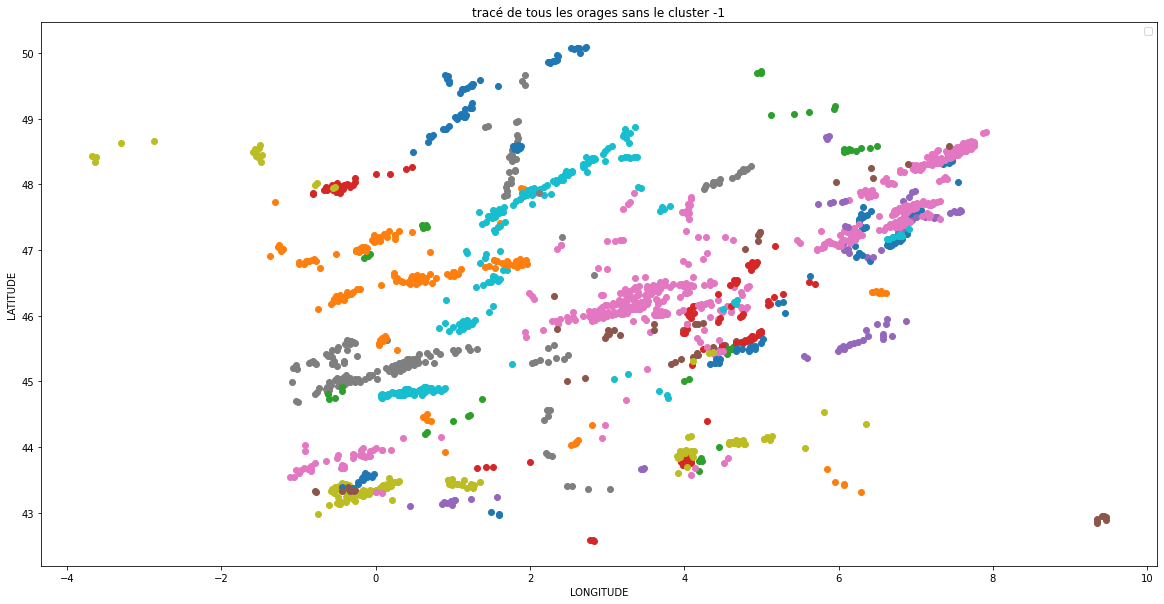

In [22]:
grid(df5,'FR',2022,spatial_params,time_fix,sample_fix)

#Influence of time threshold in st_dbscan

In [23]:
spatial_fix = [0.3]
sample_fix = [2]

model = spatial:  0.4 , time : 1 , min_samples : 3
we cluster 93 orages in FR during the year 2022
we can't cluster 175 obsverations over 1980 ( 8.8 %)
In FR during the year 2022 the mean number of observations per orage is 19.409
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


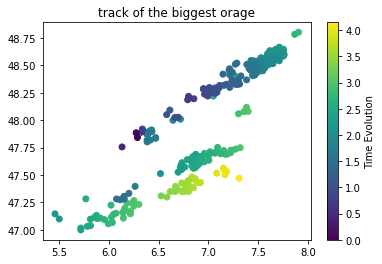

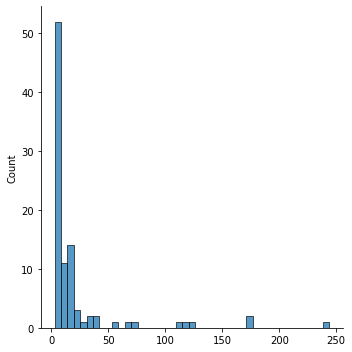

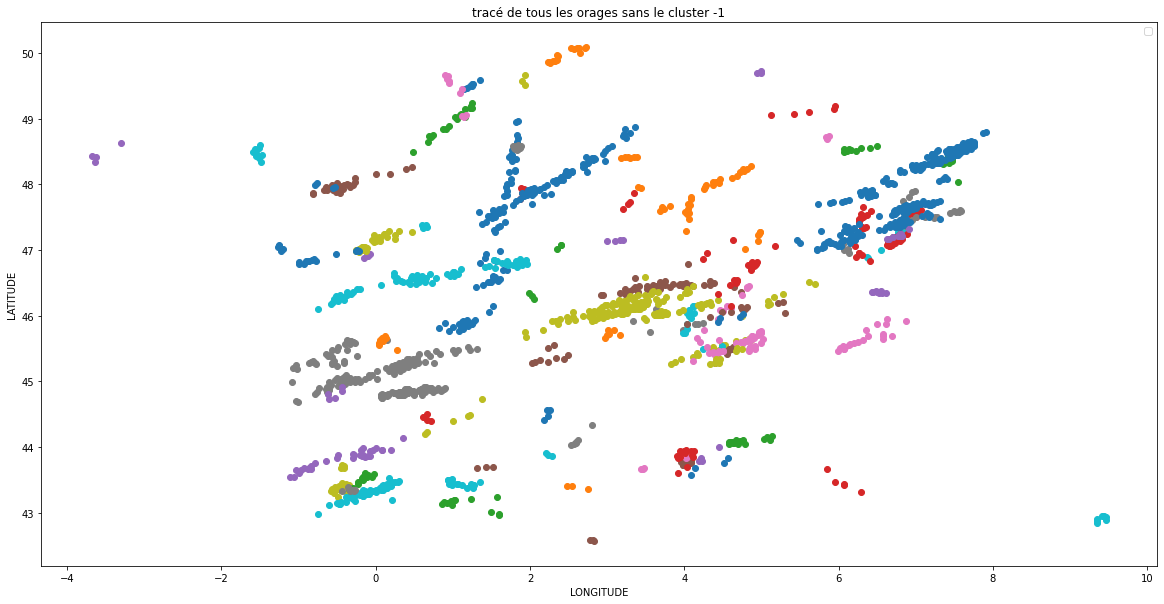

model = spatial:  0.4 , time : 2 , min_samples : 3
we cluster 86 orages in FR during the year 2022
we can't cluster 156 obsverations over 1980 ( 7.9 %)
In FR during the year 2022 the mean number of observations per orage is 21.209
In FR during the year 2022 the median number of observations per orage is 7.5
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


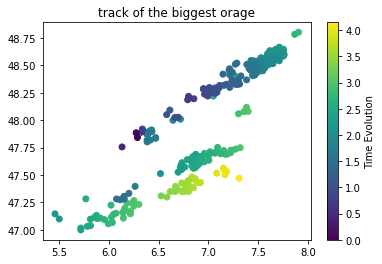

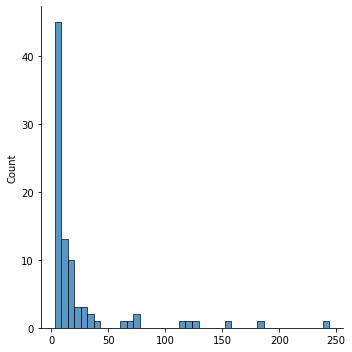

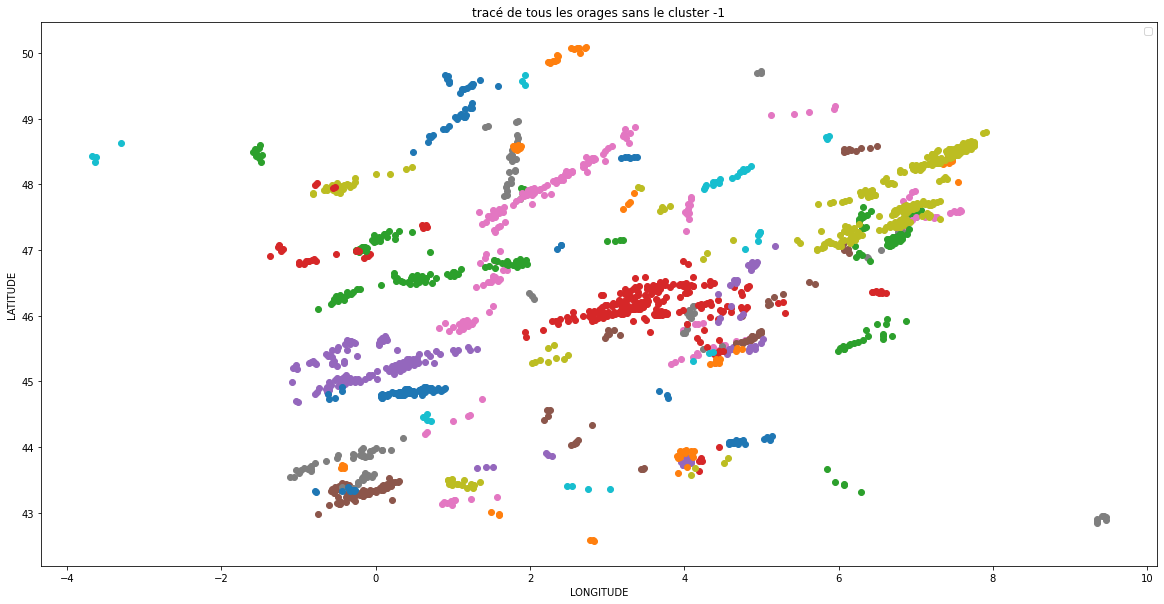

model = spatial:  0.4 , time : 3 , min_samples : 3
we cluster 84 orages in FR during the year 2022
we can't cluster 156 obsverations over 1980 ( 7.9 %)
In FR during the year 2022 the mean number of observations per orage is 21.714
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


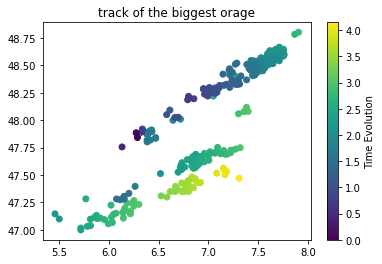

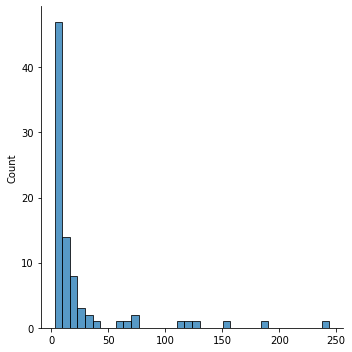

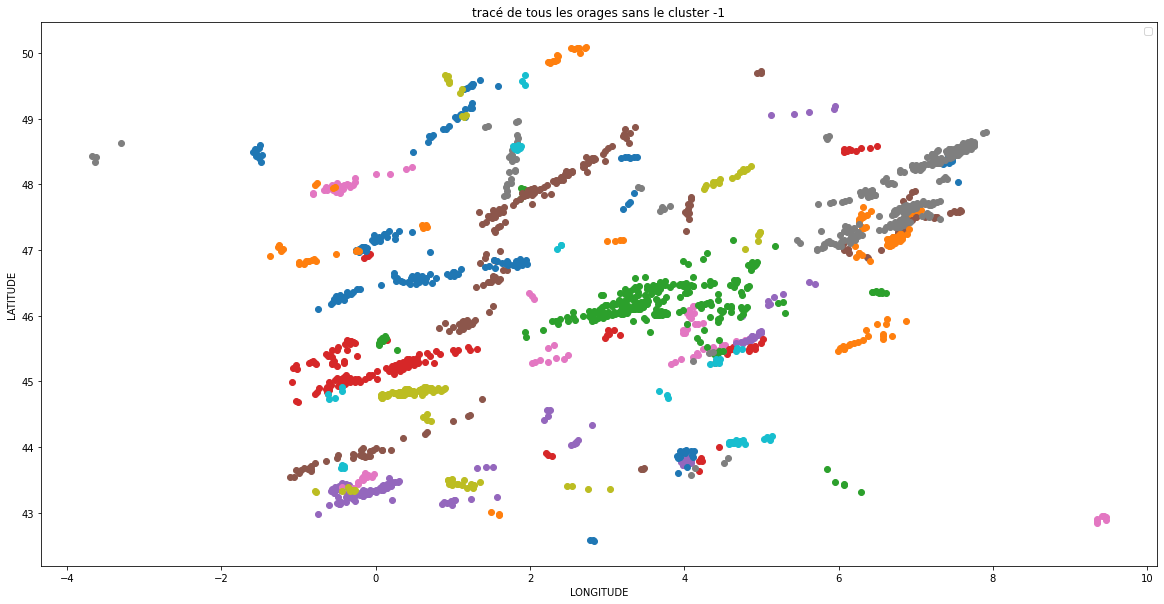

model = spatial:  0.4 , time : 4 , min_samples : 3
we cluster 84 orages in FR during the year 2022
we can't cluster 153 obsverations over 1980 ( 7.7 %)
In FR during the year 2022 the mean number of observations per orage is 21.75
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


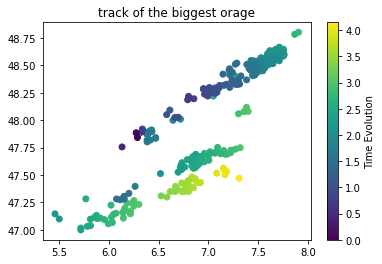

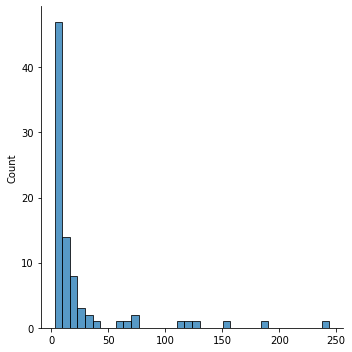

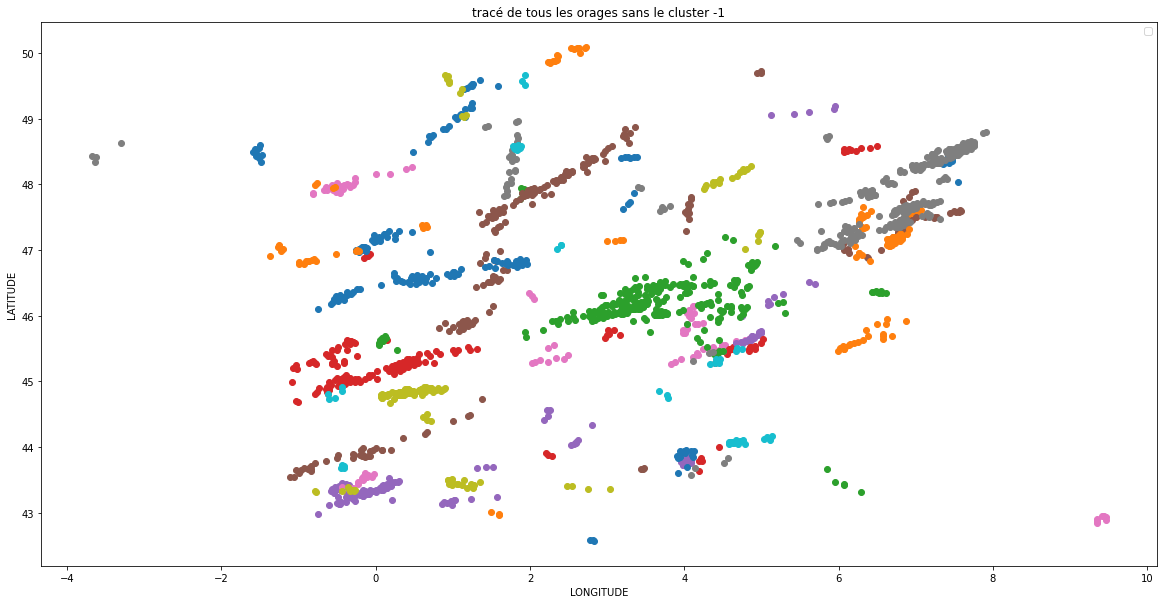

model = spatial:  0.4 , time : 5 , min_samples : 3
we cluster 84 orages in FR during the year 2022
we can't cluster 151 obsverations over 1980 ( 7.6 %)
In FR during the year 2022 the mean number of observations per orage is 21.774
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


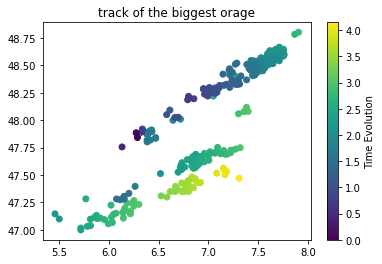

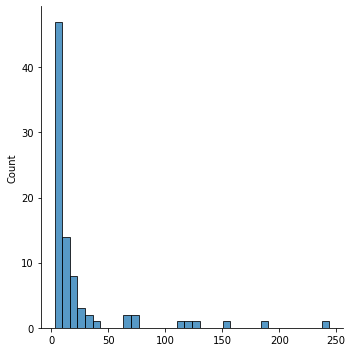

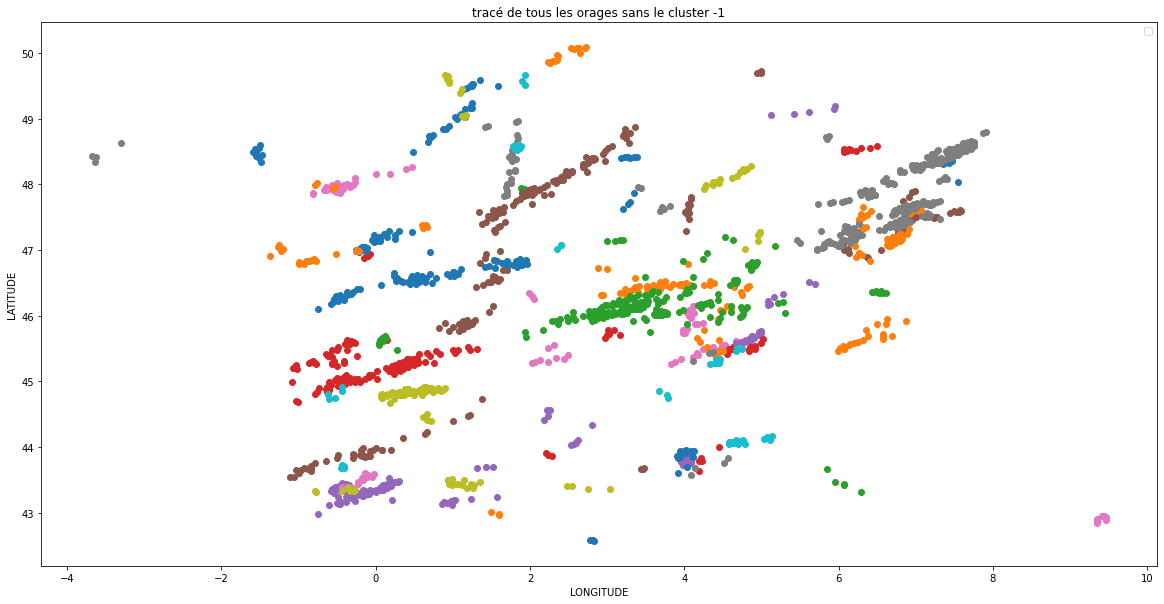

model = spatial:  0.4 , time : 6 , min_samples : 3
we cluster 84 orages in FR during the year 2022
we can't cluster 151 obsverations over 1980 ( 7.6 %)
In FR during the year 2022 the mean number of observations per orage is 21.774
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


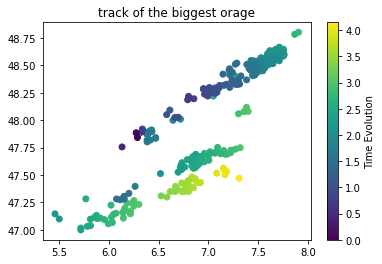

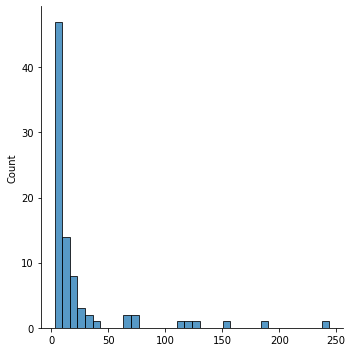

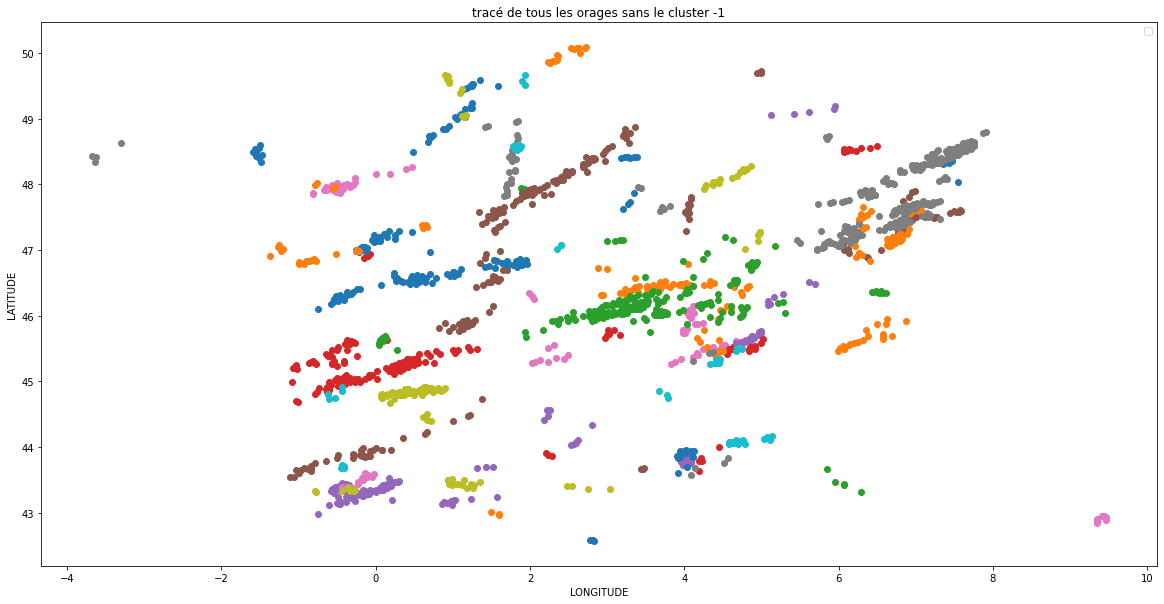

model = spatial:  0.4 , time : 7 , min_samples : 3
we cluster 85 orages in FR during the year 2022
we can't cluster 148 obsverations over 1980 ( 7.5 %)
In FR during the year 2022 the mean number of observations per orage is 21.553
In FR during the year 2022 the median number of observations per orage is 8.0
the biggest orage has been reported 244 times
the biggest orage has moved : 2.448 longitude degrees and 1.801 latitude degrees
the biggest orage has last : 4 h 6 min


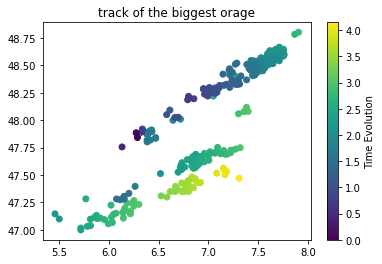

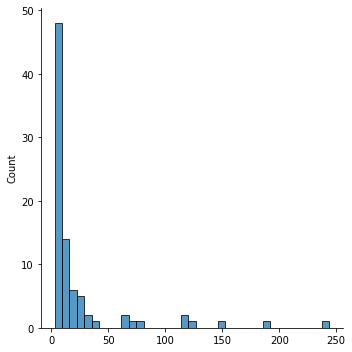

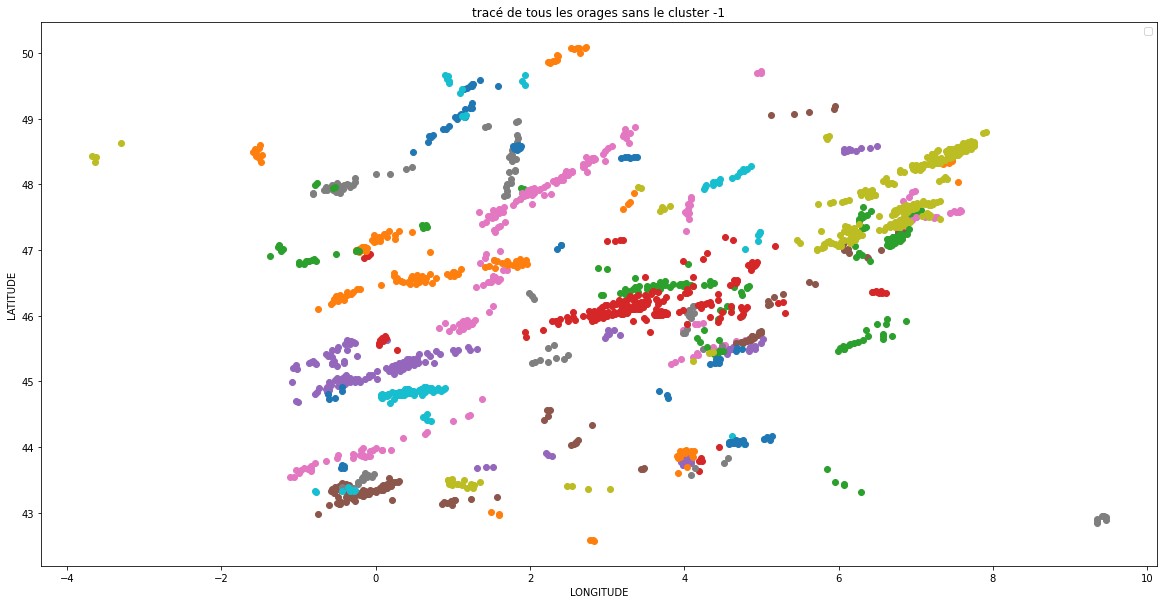

In [25]:
grid(df5,'FR',2022,spatial_fix,time_params,sample_fix)

The biggest orage isn't changed at all by the time parameter ! The mean number of observations per orage seems constant to 21,5. Results seem pretty identical, not a big influence of the time parameter.


#Influence of min samples parameter

In [26]:
spatial_fix = [0.2]
time_fix = [2]

model = spatial:  0.2 , time : 2 , min_samples : 1
we cluster 298 orages in FR during the year 2022
we can't cluster 2 obsverations over 1980 ( 0.1 %)
In FR during the year 2022 the mean number of observations per orage is 6.638
In FR during the year 2022 the median number of observations per orage is 2.0
the biggest orage has been reported 164 times
the biggest orage has moved : 0.0 longitude degrees and 0.0 latitude degrees
the biggest orage has last : 0 h 0 min


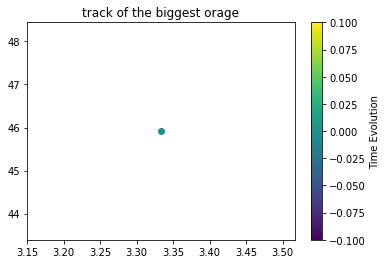

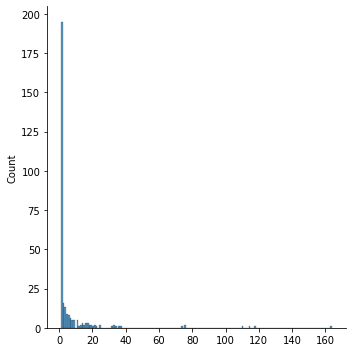

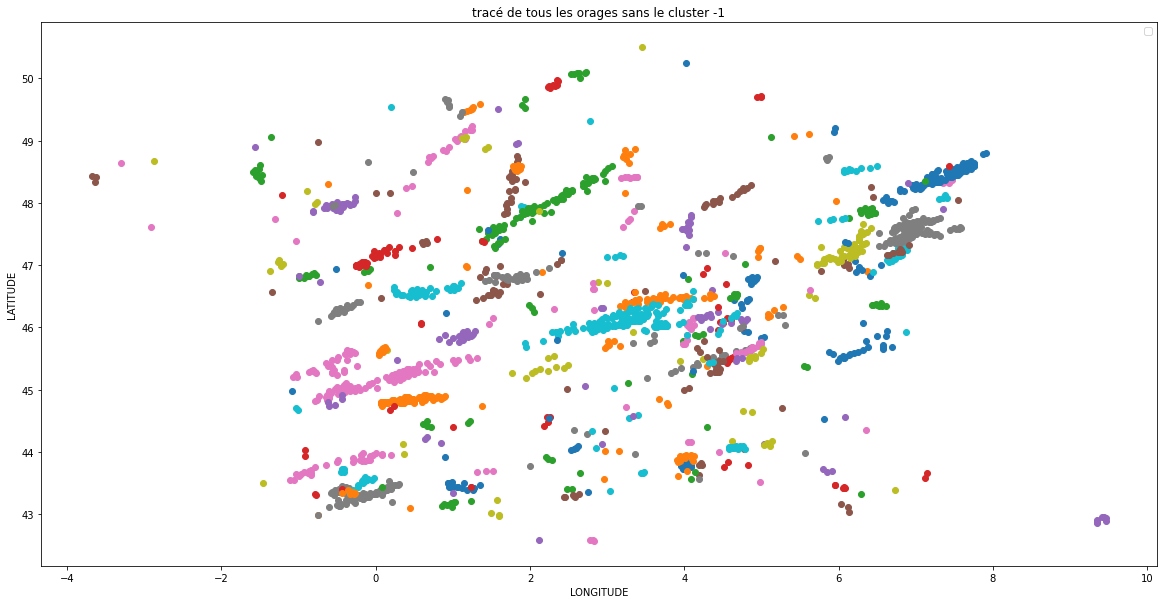

model = spatial:  0.2 , time : 2 , min_samples : 2
we cluster 160 orages in FR during the year 2022
we can't cluster 139 obsverations over 1980 ( 7.0 %)
In FR during the year 2022 the mean number of observations per orage is 11.506
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


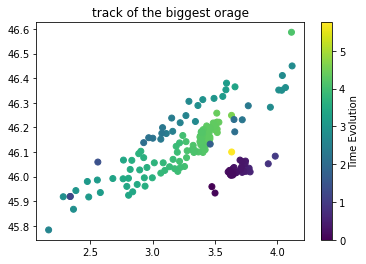

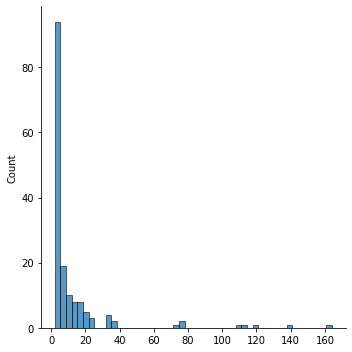

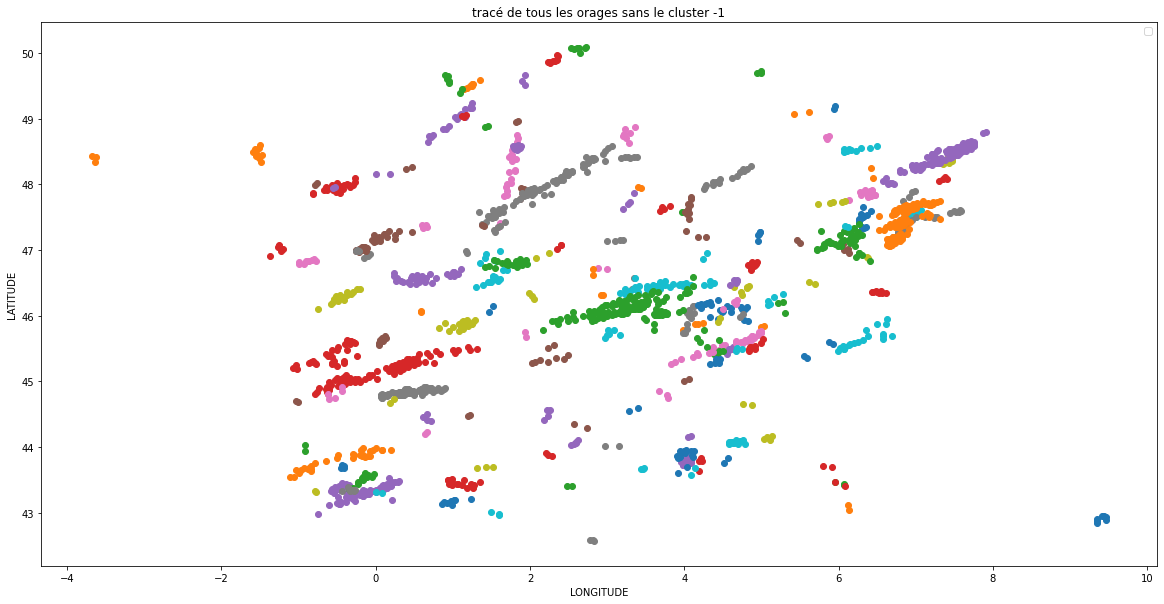

model = spatial:  0.2 , time : 2 , min_samples : 3
we cluster 104 orages in FR during the year 2022
we can't cluster 251 obsverations over 1980 ( 12.7 %)
In FR during the year 2022 the mean number of observations per orage is 16.625
In FR during the year 2022 the median number of observations per orage is 7.5
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


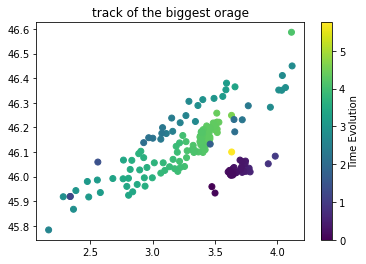

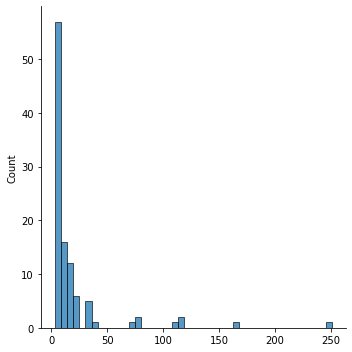

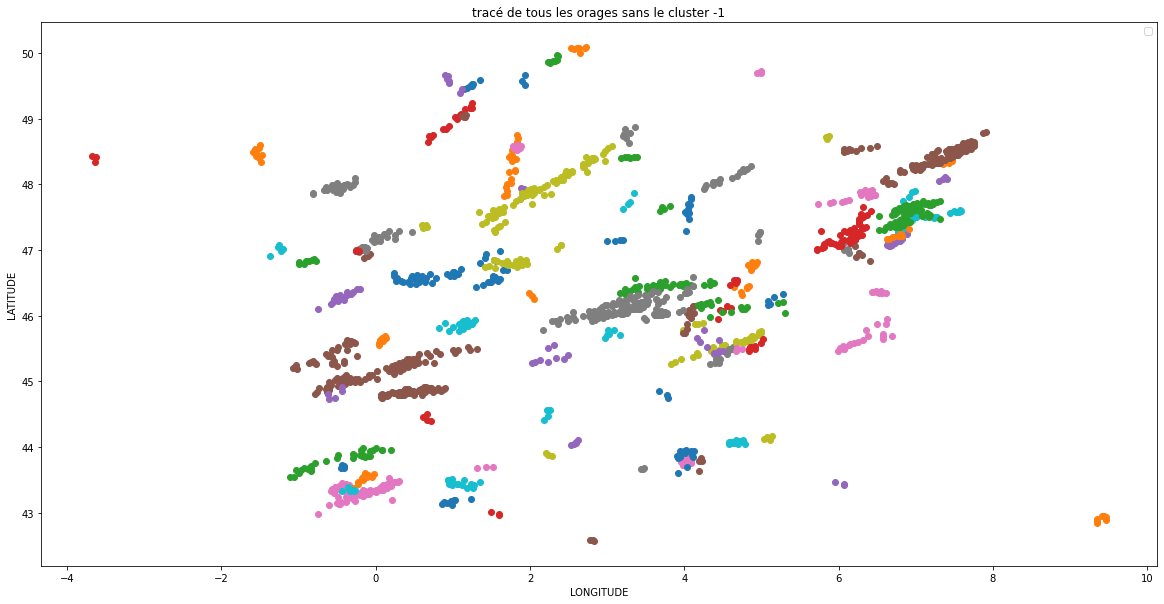

model = spatial:  0.2 , time : 2 , min_samples : 4
we cluster 88 orages in FR during the year 2022
we can't cluster 299 obsverations over 1980 ( 15.1 %)
In FR during the year 2022 the mean number of observations per orage is 19.102
In FR during the year 2022 the median number of observations per orage is 9.0
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


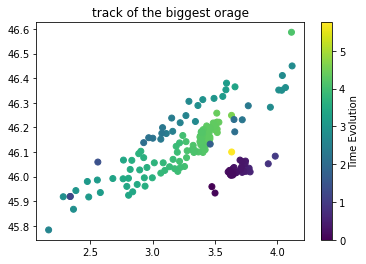

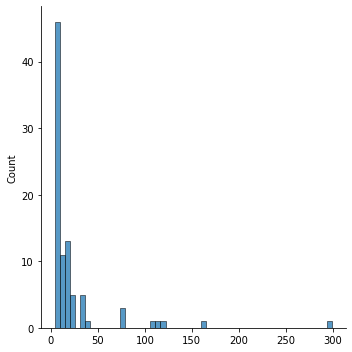

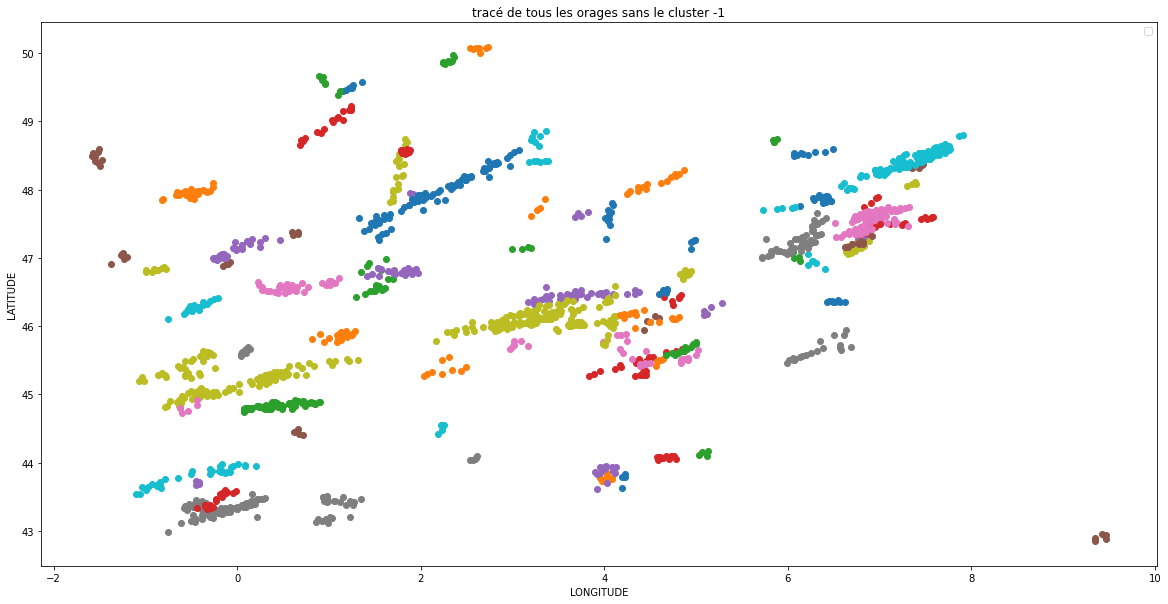

model = spatial:  0.2 , time : 2 , min_samples : 5
we cluster 77 orages in FR during the year 2022
we can't cluster 370 obsverations over 1980 ( 18.7 %)
In FR during the year 2022 the mean number of observations per orage is 20.909
In FR during the year 2022 the median number of observations per orage is 11.0
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


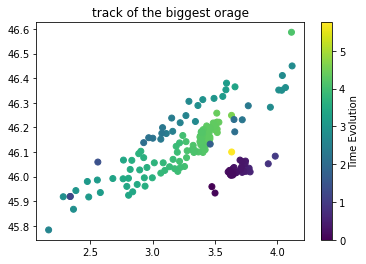

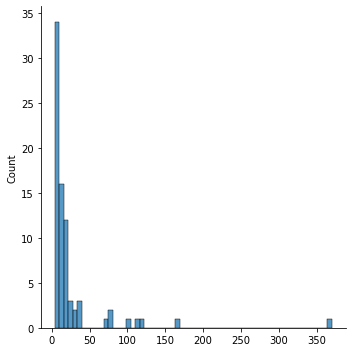

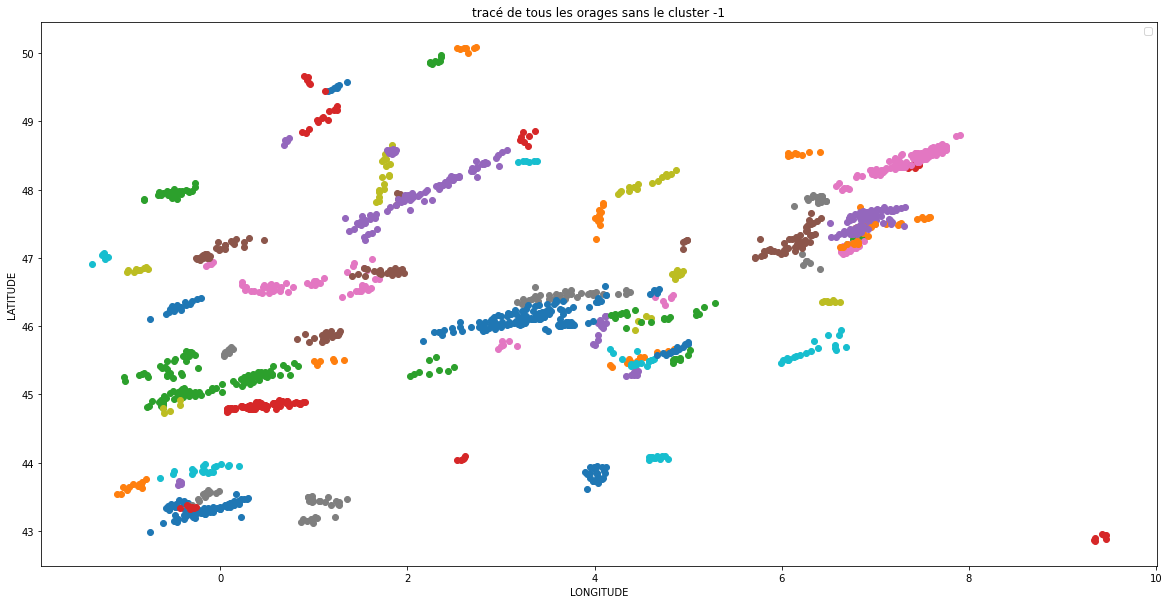

model = spatial:  0.2 , time : 2 , min_samples : 6
we cluster 69 orages in FR during the year 2022
we can't cluster 426 obsverations over 1980 ( 21.5 %)
In FR during the year 2022 the mean number of observations per orage is 22.522
In FR during the year 2022 the median number of observations per orage is 12.0
the biggest orage has been reported 164 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 5 h 48 min


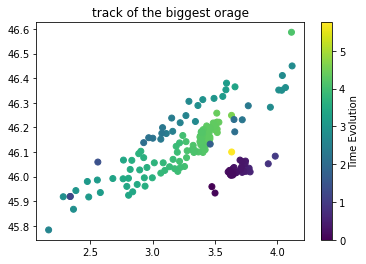

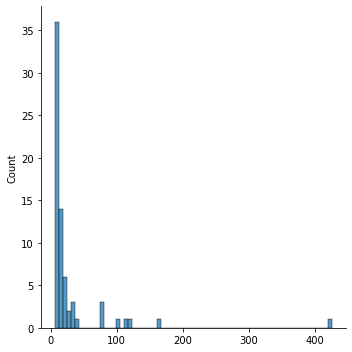

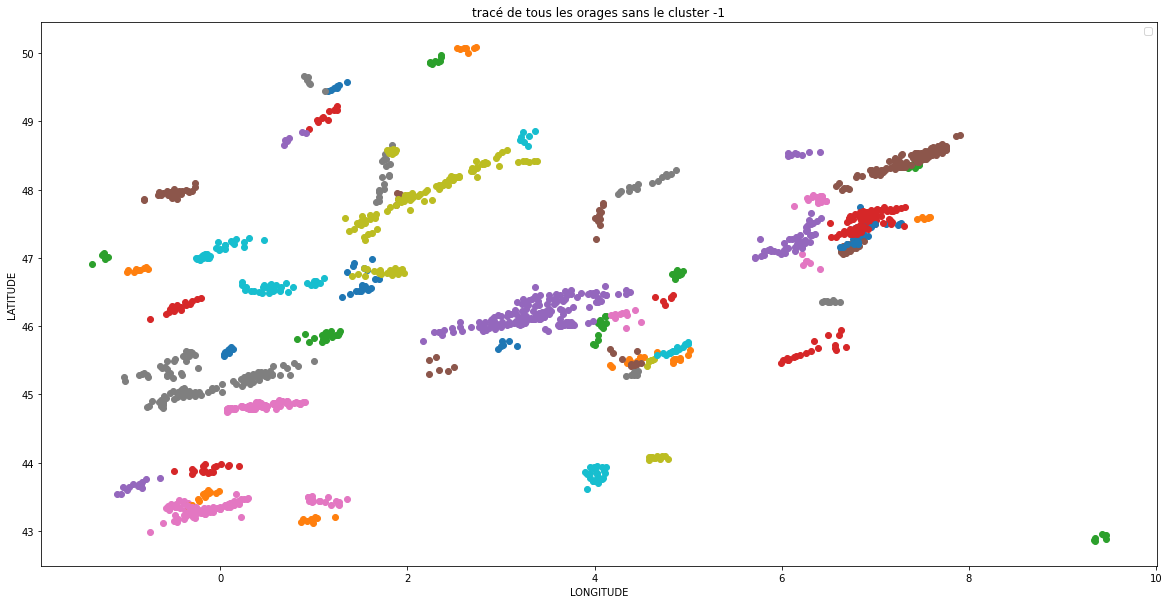

model = spatial:  0.2 , time : 2 , min_samples : 7
we cluster 61 orages in FR during the year 2022
we can't cluster 502 obsverations over 1980 ( 25.4 %)
In FR during the year 2022 the mean number of observations per orage is 24.23
In FR during the year 2022 the median number of observations per orage is 13.0
the biggest orage has been reported 157 times
the biggest orage has moved : 1.697 longitude degrees and 0.513 latitude degrees
the biggest orage has last : 5 h 48 min


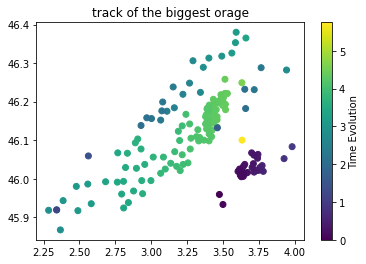

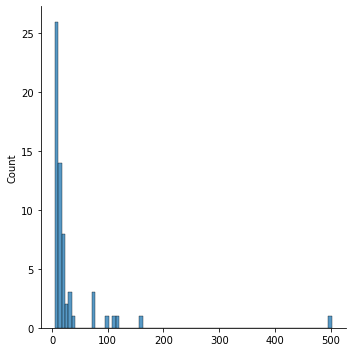

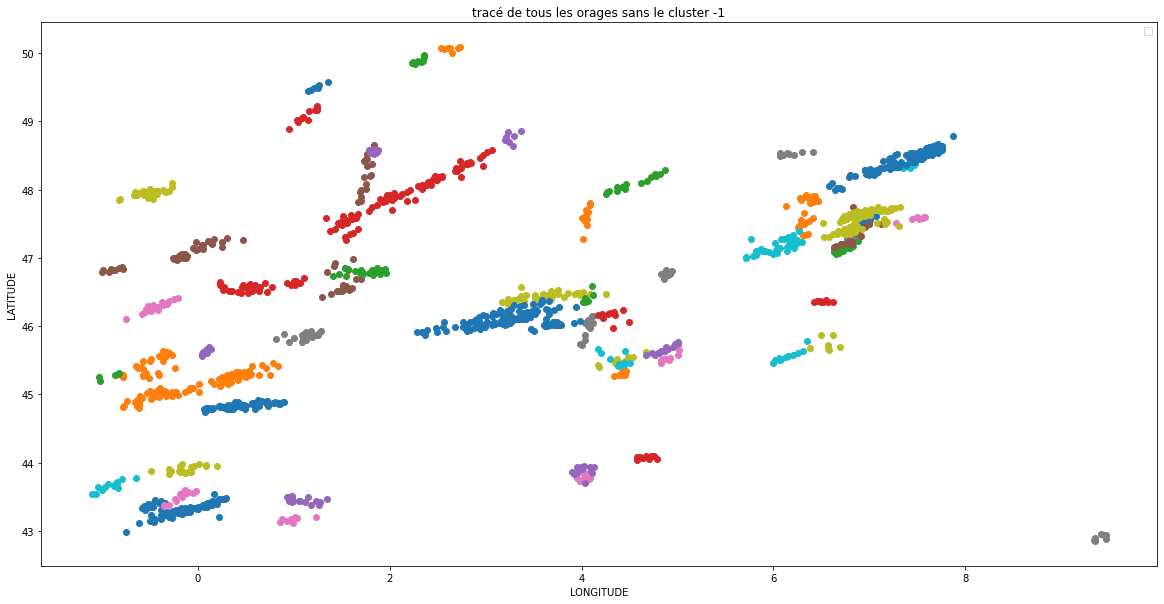

In [27]:
grid(df5,'FR',2022,spatial_fix,time_fix,sample_params)

Il faut un petit min_samples sinon beaucoup trop clusterisé. Pb biggest track min_samples = 1. Sinon choix entre 1 et 3.

A l'oeil, eps1 = 0.4, eps2 = 5, min_samples = 3

Idée : on cluster d'abord les rapports précis. Logiquement, bon modèle et on ajoute 1 à 1 les autres rapports de moins en moins précis en augmentant peu à peu les seuils.

model = spatial:  0.2 , time : 3 , min_samples : 2
we cluster 160 orages in FR during the year 2022
we can't cluster 137 obsverations over 1980 ( 6.9 %)
In FR during the year 2022 the mean number of observations per orage is 11.519
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 165 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 6 h 30 min


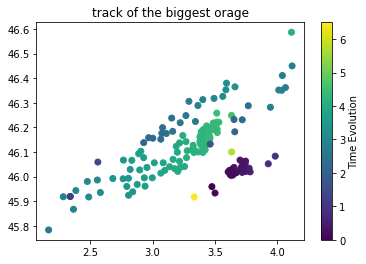

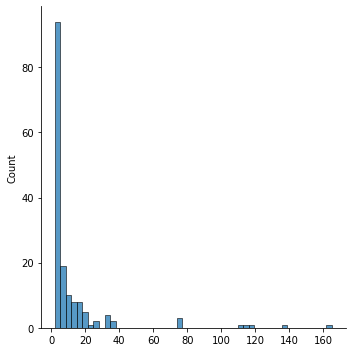

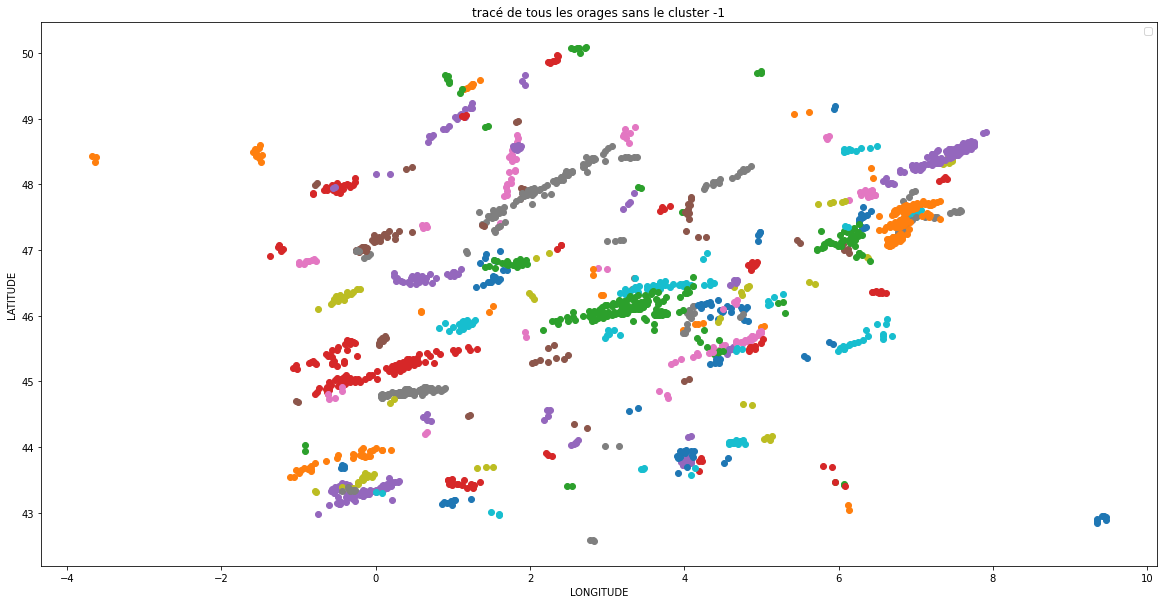

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,0
1,138375.783333,45.596,5.875,0
4,138358.416667,49.583,1.358,1
5,138358.333333,49.533,1.267,1
6,138358.3,49.521,1.251,1
...,...,...,...,...
7274,133961.583333,43.279,2.460,158
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,159
7309,133604.083333,48.636,4.952,159


In [41]:
visu(df5,'FR',2022,0.2,3,2)

model = spatial:  0.2 , time : 2 , min_samples : 2
we cluster 47 orages in FR during the year 2021
we can't cluster 51 obsverations over 238 ( 21.4 %)
In FR during the year 2021 the mean number of observations per orage is 3.979
In FR during the year 2021 the median number of observations per orage is 3.0
the biggest orage has been reported 11 times
the biggest orage has moved : 0.094 longitude degrees and 0.15 latitude degrees
the biggest orage has last : 0 h 18 min


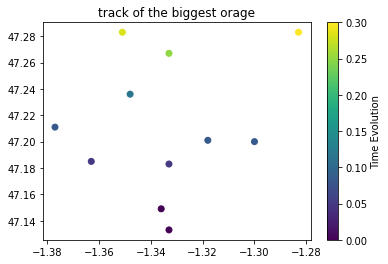

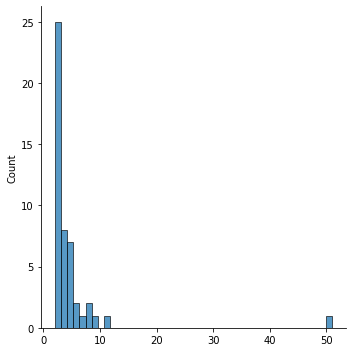

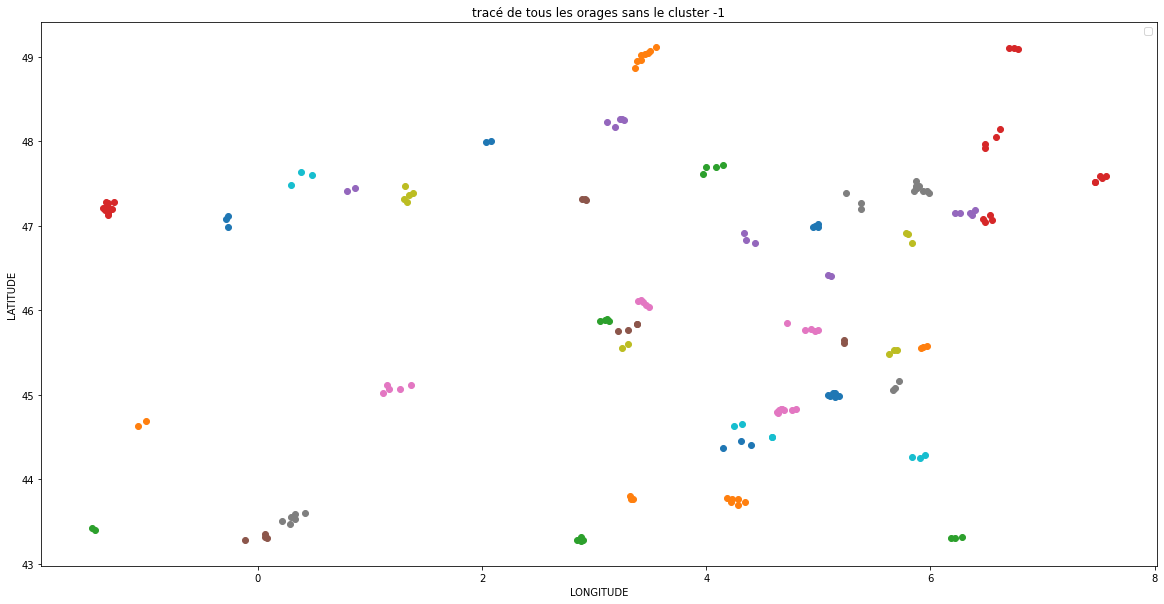

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
7505,128687.916667,43.667,3.717,-1
7507,128663.166667,48.000,2.083,0
7508,128663.083333,47.987,2.040,0
7510,128654.75,43.733,4.350,1
7511,128654.416667,43.767,4.283,1
...,...,...,...,...
12680,125082.416667,41.917,8.733,-1
12734,124123.916667,43.600,7.000,46
12735,124123.416667,43.633,6.999,46
12736,124123.0,43.633,7.100,46


In [58]:
visu(df5,'FR',2021,0.2,2,2)

model = spatial:  0.2 , time : 2 , min_samples : 2
we cluster 14 orages in FR during the year 2020
we can't cluster 57 obsverations over 93 ( 61.3 %)
In FR during the year 2020 the mean number of observations per orage is 2.571
In FR during the year 2020 the median number of observations per orage is 2.0
the biggest orage has been reported 57 times
the biggest orage has moved : 9.067 longitude degrees and 7.333 latitude degrees


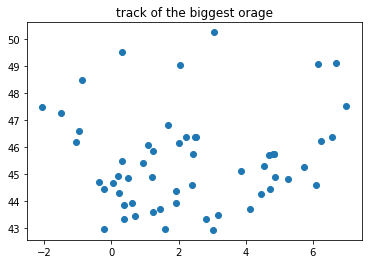

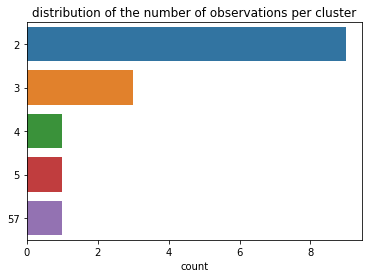

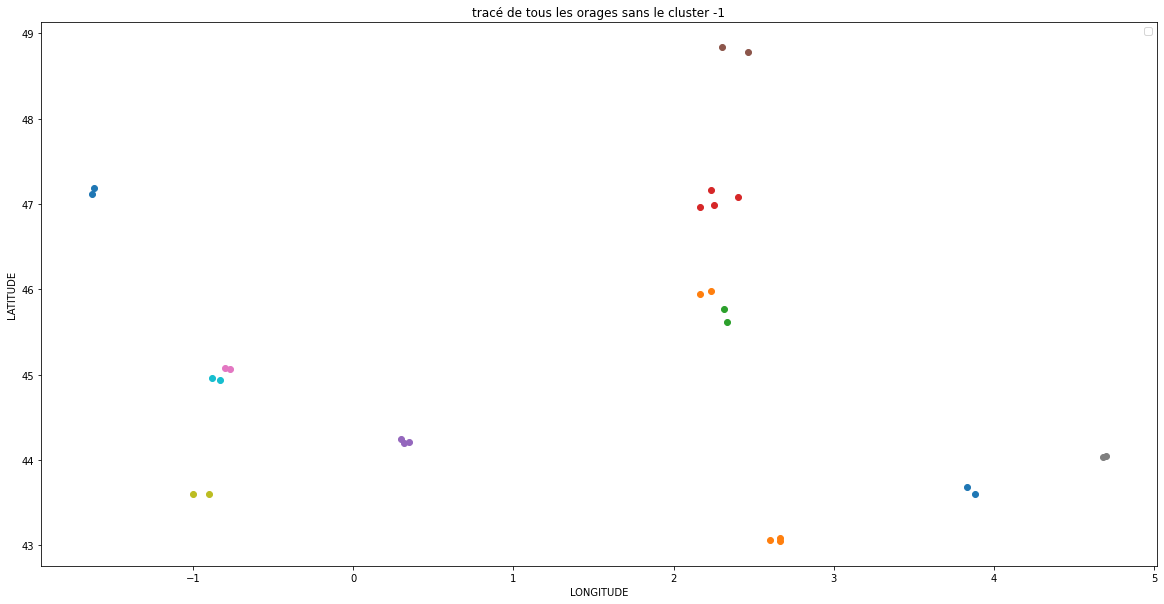

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
12773,122391.916667,47.467,-2.067,-1
12799,120836.916667,43.333,2.817,-1
12800,120835.916667,43.600,3.883,0
12801,120835.916667,43.683,3.833,0
12802,120835.916667,43.683,4.133,-1
...,...,...,...,...
15975,116301.416667,42.917,3.033,-1
15976,116301.416667,44.883,-0.100,12
15977,116273.166667,50.183,2.983,13
15978,116273.166667,50.167,3.000,13


In [ ]:
visu(df5,'FR',2020,0.2,2,2)

## ON CHOISIT EPS1 = 0.2, EPS2 = 3 ET MIN_SAMPLES = 2


model = spatial:  0.2 , time : 3 , min_samples : 2
we cluster 160 orages in FR during the year 2022
we can't cluster 137 obsverations over 1980 ( 6.9 %)
In FR during the year 2022 the mean number of observations per orage is 11.519
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 165 times
the biggest orage has moved : 1.949 longitude degrees and 0.804 latitude degrees
the biggest orage has last : 6 h 30 min


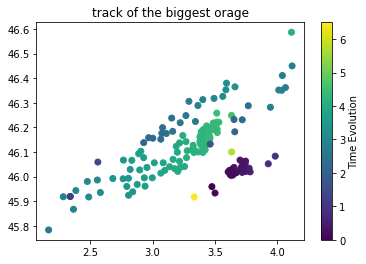

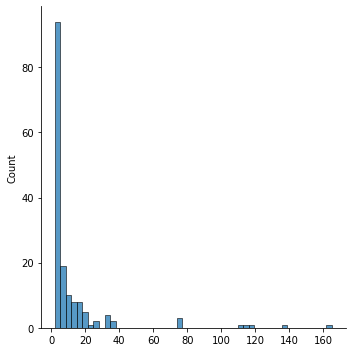

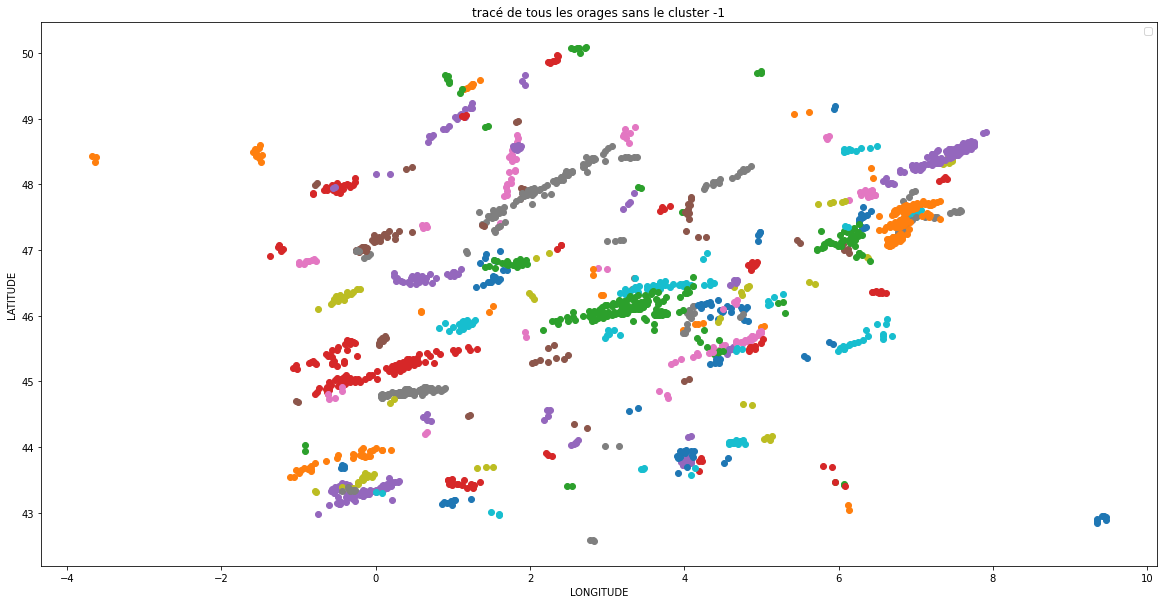

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,0
1,138375.783333,45.596,5.875,0
4,138358.416667,49.583,1.358,1
5,138358.333333,49.533,1.267,1
6,138358.3,49.521,1.251,1
...,...,...,...,...
7274,133961.583333,43.279,2.460,158
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,159
7309,133604.083333,48.636,4.952,159


In [29]:
visu(df5,'FR',2022,0.2,3,2)

On voit clairement 3 tracks distinctes dans le biggest orage en France 2022 avec les paramètres retenus

model = spatial:  0.11 , time : 3 , min_samples : 2
we cluster 200 orages in FR during the year 2022
we can't cluster 213 obsverations over 1980 ( 10.8 %)
In FR during the year 2022 the mean number of observations per orage is 8.835
In FR during the year 2022 the median number of observations per orage is 4.0
the biggest orage has been reported 118 times
the biggest orage has moved : 0.833 longitude degrees and 0.169 latitude degrees
the biggest orage has last : 2 h 42 min


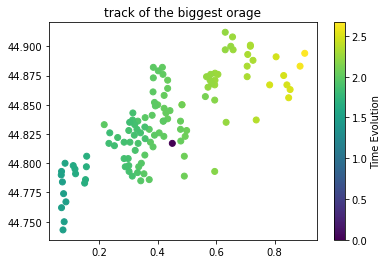

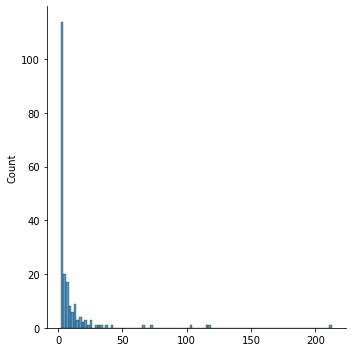

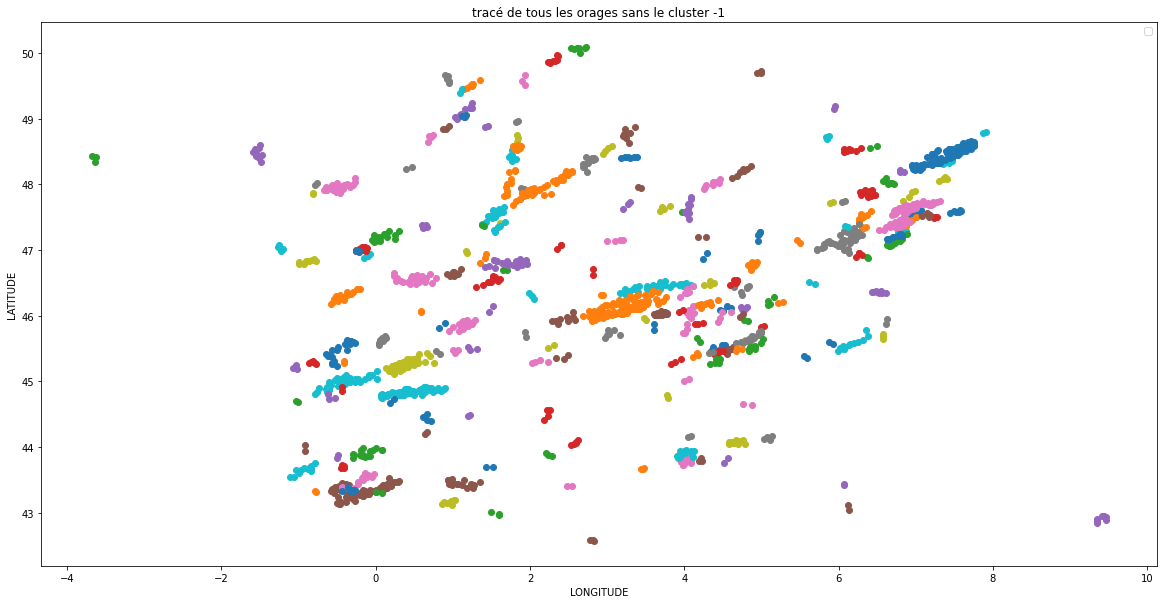

,TIME_EVENT,LATITUDE,LONGITUDE,CLASSI
0,138376.166667,45.567,5.933,0
1,138375.783333,45.596,5.875,0
4,138358.416667,49.583,1.358,1
5,138358.333333,49.533,1.267,1
6,138358.3,49.521,1.251,1
...,...,...,...,...
7274,133961.583333,43.279,2.460,199
7275,133944.416667,44.600,-0.933,-1
7308,133604.2,48.669,5.114,-1
7309,133604.083333,48.636,4.952,-1


In [30]:
visu(df5,'FR',2022,0.11,3,2)

In [ ]:
# on veut récupérer les clusters -1 en France 2022 avec différents paramètres et les comparer entre eux

In [31]:
def get_trash(df5,country,year,var_eps1,var_eps2,var_min_samples):
  #print('model = spatial: ',var_eps1,', time :',var_eps2,', min_samples :',var_min_samples )
  data = df5[df5.YEAR == year]
  data = data[data.COUNTRY == country]
  data_visu = data[['TIME_EVENT','LATITUDE','LONGITUDE']]
  model_visu = ST_DBSCAN(eps1=var_eps1, eps2=var_eps2,
                         min_samples=var_min_samples)
  model_visu.fit(data_visu)
  classi_visu = model_visu.labels
  visu_results = data_visu.copy()
  visu_results['CLASSI'] = classi_visu
  visu_bis = visu_results.reset_index(drop = True)
  return set(visu_bis[visu_bis.CLASSI == -1].index),visu_bis


In [32]:
get_trash(df5,'FR',2022,0.2,3,2)

({24,
  25,
  28,
  44,
  53,
  59,
  60,
  61,
  64,
  66,
  72,
  77,
  78,
  79,
  80,
  81,
  84,
  86,
  90,
  145,
  146,
  150,
  152,
  156,
  157,
  158,
  167,
  171,
  172,
  173,
  178,
  180,
  205,
  218,
  221,
  222,
  223,
  224,
  225,
  226,
  231,
  232,
  237,
  238,
  239,
  241,
  246,
  247,
  329,
  343,
  371,
  372,
  386,
  392,
  415,
  416,
  661,
  662,
  679,
  680,
  694,
  711,
  712,
  713,
  725,
  737,
  743,
  746,
  749,
  751,
  754,
  777,
  806,
  911,
  1049,
  1113,
  1141,
  1211,
  1215,
  1218,
  1239,
  1242,
  1243,
  1245,
  1246,
  1250,
  1251,
  1368,
  1373,
  1387,
  1388,
  1400,
  1430,
  1476,
  1477,
  1487,
  1528,
  1533,
  1536,
  1539,
  1544,
  1545,
  1548,
  1560,
  1561,
  1576,
  1596,
  1599,
  1602,
  1614,
  1615,
  1625,
  1685,
  1790,
  1823,
  1843,
  1844,
  1863,
  1877,
  1914,
  1915,
  1916,
  1925,
  1928,
  1929,
  1930,
  1933,
  1939,
  1940,
  1950,
  1955,
  1964,
  1967,
  1968,
  1969,
  1976,
  197

In [33]:
params_spatial = np.linspace(0.05,0.25,50)

In [38]:
def plot_trash(df5,country,year,params_spatial,var_eps2,min_samples):
  len_trash = []
  for e in params_spatial:
    len_trash.append(len(get_trash(df5,'FR',year,e,var_eps2,min_samples)[0]))
    #print('longueur du cluster -1 =',len(get_trash(df5,'FR',year,e,var_eps2,min_samples)),'pour eps_1 =',e)
  plt.scatter(params_spatial,len_trash)
  plt.title('Number of unclassified observations for different spatial parameters')
  plt.xlabel('eps_1')
  plt.show()

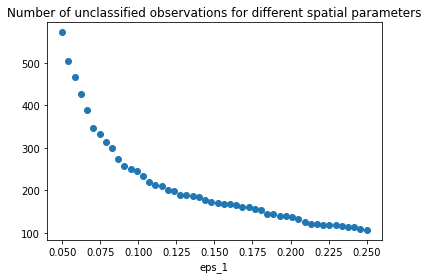

In [39]:
plot_trash(df5,'FR',2022,params_spatial,3,2)

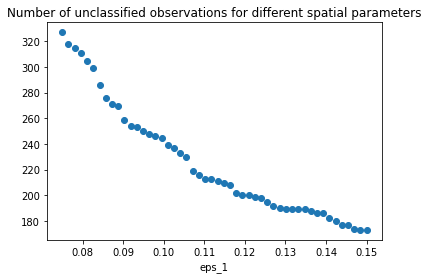

In [40]:
plot_trash(df5,'FR',2022,np.linspace(0.075,0.15,50),3,2)

In [41]:
test = np.linspace(0.075,0.15,50)
values = []
for i in range(len(test)-1):
  values.append(get_trash(df5,'FR',2022,test[i+1],3,2)[0].issubset(get_trash(df5,'FR',2022,test[i],3,2)[0]))
a = sum(values)
print (a == len(test)-1)

True


Cela montre que tous les clusters -1 sont des sous-ensembles imbriqués. Ils forment une suite décroissante au sens de l'inclusion lorsque eps_1 augmente

In [43]:
get_trash(df5,'FR',2022,25,5,2)

({59, 66, 172, 173, 329, 1211, 1215, 1976, 1979},
          TIME_EVENT  LATITUDE  LONGITUDE  CLASSI
 0     138376.166667    45.567      5.933       0
 1     138375.783333    45.596      5.875       0
 2     138358.416667    49.583      1.358       1
 3     138358.333333    49.533      1.267       1
 4          138358.3    49.521      1.251       1
 ...             ...       ...        ...     ...
 1975  133961.583333    43.279      2.460      43
 1976  133944.416667    44.600     -0.933      -1
 1977       133604.2    48.669      5.114      44
 1978  133604.083333    48.636      4.952      44
 1979  132910.916667    44.750     -0.533      -1
 
 [1980 rows x 4 columns])

{59, 66, 172, 173, 329, 1211, 1215, 1976, 1979} sont les index des rapports en France 2022 qu'on ne pourra jamais classer

In [ ]:
get_trash(df5,'FR',2022,0.2,3,2)

In [44]:
from random import *

In [50]:
def plot_solo(df5,country,year,eps1,eps2,min_samples):
  trash_cluster,df = get_trash(df5,country,year,eps1,eps2,min_samples)
  trash_cluster = list(trash_cluster)
  n = len(trash_cluster)
  obs = randint(0,n-1)
  index = trash_cluster[obs]
  print("on regarde pour le rapport d'index",index)
  lati,longi,temps = df.iloc[index,1],df.iloc[index,2],df.iloc[index,0]
  index_low, index_high = index,index
  while df.iloc[index_low,-1] == -1:
    index_low-=1
  while df.iloc[index_high,-1] == -1:
    index_high+=1
  classi_low,classi_high = df.iloc[index_low,-1],df.iloc[index_high,-1]
  df_low_low,df_low,df_high,df_high_high = df[df.CLASSI == classi_low-1],df[df.CLASSI == classi_low],df[df.CLASSI == classi_high],df[df.CLASSI == classi_high+1]
  plt.figure(1)
  longitude_low_low = [df_low_low.iloc[i,2] for i in range(len(df_low_low))]
  latitude_low_low = [df_low_low.iloc[i,1] for i in range(len(df_low_low))]
  temps_low_low = [df_low_low.iloc[i,0] - df_low_low.iloc[-1,0] for i in range(len(df_low_low))]
  longitude_low_low.append(longi),latitude_low_low.append(lati),temps_low_low.append(temps - df_low_low.iloc[-1,0])
  plt.scatter(longitude_low_low,latitude_low_low, c = temps_low_low)
  cbar = plt.colorbar()
  cbar.set_label('Time Evolution')
  print('track du',classi_low-1,'ème orage')
  plt.show()
  plt.figure(2)
  longitude_low = [df_low.iloc[i,2] for i in range(len(df_low))]
  latitude_low = [df_low.iloc[i,1] for i in range(len(df_low))]
  temps_low = [df_low.iloc[i,0] - df_low.iloc[-1,0] for i in range(len(df_low))]
  longitude_low.append(longi),latitude_low.append(lati),temps_low.append(temps - df_low.iloc[-1,0])
  plt.scatter(longitude_low,latitude_low, c = temps_low)
  cbar = plt.colorbar()
  cbar.set_label('Time Evolution')
  print('track du',classi_low,'ème orage')
  plt.show()
  plt.figure(3)
  longitude_high = [df_high.iloc[i,2] for i in range(len(df_high))]
  latitude_high = [df_high.iloc[i,1] for i in range(len(df_high))]
  temps_high = [df_high.iloc[i,0] - df_high.iloc[-1,0] for i in range(len(df_high))]
  longitude_high.append(longi),latitude_high.append(lati),temps_high.append(temps - df_high.iloc[-1,0])
  plt.scatter(longitude_high,latitude_high, c = temps_high)
  cbar = plt.colorbar()
  cbar.set_label('Time Evolution')
  print('track du',classi_high,'ème orage')
  plt.show()
  plt.figure(4)
  longitude_high_high = [df_high_high.iloc[i,2] for i in range(len(df_high_high))]
  latitude_high_high = [df_high_high.iloc[i,1] for i in range(len(df_high_high))]
  temps_high_high = [df_high_high.iloc[i,0] - df_high_high.iloc[-1,0] for i in range(len(df_high_high))]
  longitude_high_high.append(longi),latitude_high_high.append(lati),temps_high_high.append(temps - df_high_high.iloc[-1,0])
  plt.scatter(longitude_high_high,latitude_high_high, c = temps_high_high)
  cbar = plt.colorbar()
  cbar.set_label('Time Evolution')
  print('track du',classi_high+1,'ème orage')
  plt.show()  

on regarde pour le rapport d'index 53
track du 5 ème orage


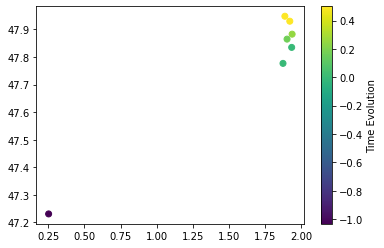

track du 6 ème orage


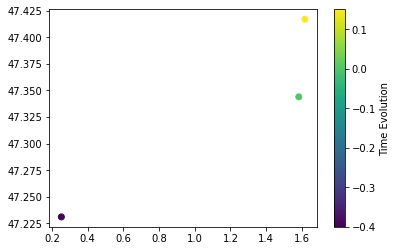

track du 7 ème orage


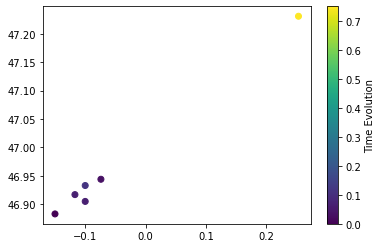

track du 8 ème orage


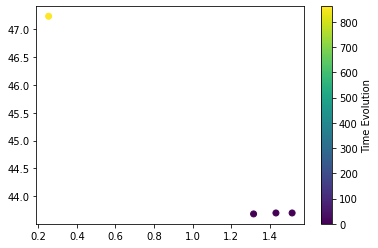

In [52]:
plot_solo(df5,'FR',2022,0.2,3,2)

In [ ]:
#le 54ème rapport en France 2022, classé -1 par notre modèle, peut appartenir à l'orage 7.

In [53]:
from matplotlib_venn import venn2,venn2_circles

In [54]:
def constru_venn(df5,country,year,eps1_A,eps1_B,eps2,min_samples):
  A,B = get_trash(df5,country,year,eps1_A,eps2,min_samples)[0],get_trash(df5,country,year,eps1_B,eps2,min_samples)[0]
  Ab = len(A.difference(B))
  aB = len(B.difference(A))
  AB = len(A & B)
  venn2(subsets = (Ab, aB, AB), set_labels = ('eps1_A', 'eps1_B'), alpha = 0.5);
  venn2_circles(subsets = (Ab, aB, AB));
  print('eps1_A =',eps1_A,'and eps1_B =',eps1_B)
  plt.show()

eps1_A = 0.1 and eps1_B = 0.2


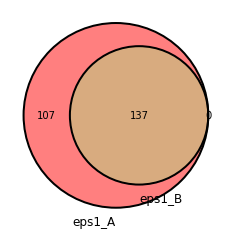

In [55]:
constru_venn(df5,'FR',2022,0.1,0.2,3,2)

eps1_A = 0.15 and eps1_B = 0.2


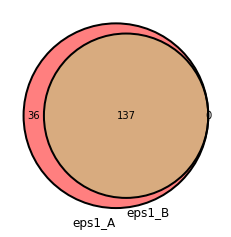

In [56]:
constru_venn(df5,'FR',2022,0.15,0.2,3,2)

eps1_A = 0.15 and eps1_B = 0.25


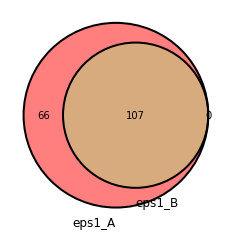

In [57]:
constru_venn(df5,'FR',2022,0.15,0.25,3,2)